# 0. Dependencies
This notebook requires three dependencies to work properly, all three which are publicly available:
1. Jupyter kernel containing the python package dependencies below. The easiest way to install a functioning kernel is to follow the step-by-step explanation in notebook `0_resources.ipynb`.
2. Region sets which can be used to calculate FRIP. You can either supply your own (e.g. generate from peak calling on aggregate data from your samples, or previous experiments), or use the ENCODE SCREEN regions, which can be downloaded from `PUMATAC_dependencies` (see notebook `0_resources.ipynb`)
3. Aligned fragments files. These can be generated using either `PUMATAC` or `cellranger`, or your own tools.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pycisTopic
import glob
import os
import pybiomart as pbm
import pandas as pd
import pickle
from pycisTopic.qc import *
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import palettable
import importlib
import pypumatac as pum  # this loads the main functions needed in this notebook.

import pprint as pp
import polars as pl
from IPython.display import Image, display

%matplotlib inline
%load_ext jupyter_black

# importlib.reload(pum)

# 1. Run basic cisTopic analysis

### 1a. Find paths to fragments
First, we will need to locate the most important files: the `fragments.tsv.gz` files for each sample! This notebook assumes that you have placed either `PUMATAC` or `cellranger` output directories within a single output directory:

The `PUMATAC` output should look like so (showing directories):

In [2]:
pumatac_output_dir = "PUMATAC_tutorial_out"

In [3]:
pum.list_files(pumatac_output_dir, maxlevel=2)

PUMATAC_tutorial_out/
    data/
        fragments/
        reports/
        bam/
    notebooks/


All fragments files of all samples are located within the `fragments/` directory.  
The Cellranger output should look like so:

In [4]:
cr_output_dir = "cellranger_out"

In [5]:
pum.list_files(cr_output_dir, maxlevel=2)

Each subdirectory of `cellranger_out` contains one sample's cellranger output.  
We now get the paths to the fragments:

In [6]:
pipeline_dict = {}
fragments_path_dict = {
    os.path.basename(x).split(".fragments.tsv.gz")[0]: x
    for x in sorted(glob.glob(f"{pumatac_output_dir}/data/fragments/*fragments.tsv.gz"))
}
for x in fragments_path_dict.keys():
    pipeline_dict[x] = "PUMATAC"

cr_atac_fragments_path_dict = {
    x.split("/")[-3]: x
    for x in sorted(glob.glob(f"{cr_output_dir}/*/outs/fragments.tsv.gz"))
}
for x in cr_atac_fragments_path_dict.keys():
    pipeline_dict[x] = "cellranger-atac"

cr_arc_fragments_path_dict = {
    x.split("/")[-3]: x
    for x in sorted(glob.glob(f"{cr_output_dir}/*/outs/atac_fragments.tsv.gz"))
}
for x in cr_arc_fragments_path_dict.keys():
    pipeline_dict[x] = "cellranger-arc"

fragments_path_dict.update(cr_atac_fragments_path_dict)
fragments_path_dict.update(cr_arc_fragments_path_dict)
fragments_path_dict

{'BIO_ddseq_4': 'PUMATAC_tutorial_out/data/fragments/BIO_ddseq_4.fragments.tsv.gz',
 'EPF_hydrop_1': 'PUMATAC_tutorial_out/data/fragments/EPF_hydrop_1.fragments.tsv.gz',
 'OHS_s3atac_1': 'PUMATAC_tutorial_out/data/fragments/OHS_s3atac_1.fragments.tsv.gz',
 'VIB_10xv2_1': 'PUMATAC_tutorial_out/data/fragments/VIB_10xv2_1.fragments.tsv.gz'}

Meanwhile, we also defined which pipeline was used for which sample (will affect where some files are stored)

In [7]:
pipeline_dict

{'BIO_ddseq_4': 'PUMATAC',
 'EPF_hydrop_1': 'PUMATAC',
 'OHS_s3atac_1': 'PUMATAC',
 'VIB_10xv2_1': 'PUMATAC'}

And we now also have all the samples, which are all keys of the `fragments_path_dict` dictionary. Later, samples will be plotted in this order specific order.

In [8]:
samples = sorted(list(fragments_path_dict.keys()))
samples

['BIO_ddseq_4', 'EPF_hydrop_1', 'OHS_s3atac_1', 'VIB_10xv2_1']

We can define an alias dictionary here, for shorter names in titles of plots etc.:

In [9]:
alias_dict = {x: x for x in samples}
alias_dict

{'BIO_ddseq_4': 'BIO_ddseq_4',
 'EPF_hydrop_1': 'EPF_hydrop_1',
 'OHS_s3atac_1': 'OHS_s3atac_1',
 'VIB_10xv2_1': 'VIB_10xv2_1'}

Edit your aliases below. You can copy-paste the basic `alias_dict`:

In [10]:
# alias_dict = {
#     "BIO_ddseq_4": "PUMATAC",
#     "EPF_hydrop_1": "PUMATAC",
#     "OHS_s3atac_1": "PUMATAC",
#     "VIB_10xv2_1": "PUMATAC",
# }

### 1b. Define which genome should be used for each sample
Valid values for this notebook are `hg38`, `mm10` and `dm6`. If you use any of these three values, the notebook will download genome annotations for these genomes. If you work with other genomes, you can manually add gene annotation and regions as you please).

In [11]:
standard_genome = "hg38"

In [12]:
genome_dict = {x: standard_genome for x in samples}
genome_dict

{'BIO_ddseq_4': 'hg38',
 'EPF_hydrop_1': 'hg38',
 'OHS_s3atac_1': 'hg38',
 'VIB_10xv2_1': 'hg38'}

Manually set the real `genome_dict` here (valid values are `hg37`, `hg38` or `dm6`). If you add a non-standard genome, you will have to provide your own genome annotation later.

In [13]:
# genome_dict = {
#     "BIO_ddseq_4": "hg38",
#     "EPF_hydrop_1": "hg38",
#     "OHS_s3atac_1": "hg38",
#     "VIB_10xv2_1": "hg38",
# }

Check if all samples are included:

In [14]:
if not set(genome_dict.keys()) == set(samples):
    print("Warning, not all fragments files have genomes defined.")
else:
    print("Genomes defined for all fragments files!")

Genomes defined for all fragments files!


Create an inverse dictionary, listing the samples per genome.

In [15]:
inverse_genome_dict = {}
for sample in samples:
    genome = genome_dict[sample]
    if genome not in inverse_genome_dict:
        inverse_genome_dict[genome] = []
    inverse_genome_dict[genome].append(sample)

inverse_genome_dict

{'hg38': ['BIO_ddseq_4', 'EPF_hydrop_1', 'OHS_s3atac_1', 'VIB_10xv2_1']}

### 1c. Download a gene annotation from biomart
We need gene annotations to calculate TSS enrichment of fragments later. The following code will work for `hg38`, `hg37`, `mm10` and `dm6`.

In [16]:
annotation_dict = pum.download_genome_annotation(inverse_genome_dict)

Loading cached genome annotation hg38_annotation.tsv


A genome annotation should looks like so, in case you want to add your own:

In [17]:
annotation_dict[standard_genome]

Chromosome      Start  Strand    Gene Transcript_type
39      chrKI270711.1      24650      -1     NaN  protein_coding
40      chrKI270711.1      29626      -1     NaN  protein_coding
538     chrKI270734.1     161852      -1   PRODH  protein_coding
539     chrKI270734.1     161750      -1   PRODH  protein_coding
576     chrKI270734.1     131494       1     NaN  protein_coding
...               ...        ...     ...     ...             ...
247244           chr1  182061712      -1  ZNF648  protein_coding
247245           chr1  182058010      -1  ZNF648  protein_coding
247262           chr1   64745075       1  RAVER2  protein_coding
247263           chr1   64745095       1  RAVER2  protein_coding
247269           chr1   84506386       1  SPATA1  protein_coding

[78878 rows x 5 columns]

A common distinction between chromosomes in the annotation and in the fragments files is the omission of the prefix `chr` before the chromosome number. For example, the `dm6` genome annotation published by 10x Genomics does not contain `chr` prefix, whereas the BioMart gene annotation does. In order to remove this, we can use the following code:

In [18]:
remove_chr = False

In [19]:
if remove_chr:
    annotation_dict[standard_genome]["Chromosome"] = [
        x.split("chr")[1] for x in annotation_dict[standard_genome]["Chromosome"]
    ]

Then quickly check whether or not the chromosomes have the correct names for you:

In [20]:
annotation_dict[standard_genome]["Chromosome"].value_counts()

Chromosome
chr1             7095
chr19            5740
chr11            5253
chr2             5209
chr17            5081
chr3             4809
chr12            4564
chr16            3804
chr6             3680
chr7             3575
chr5             3407
chr4             3070
chr8             2990
chrX             2900
chr14            2793
chr10            2760
chr9             2643
chr15            2552
chr20            1878
chr22            1696
chr18            1343
chr13            1125
chr21             782
chrY              108
chrKI270728.1       5
chrKI270727.1       4
chrKI270734.1       4
chrKI270726.1       2
chrKI270713.1       2
chrKI270711.1       2
chrKI270721.1       1
chrKI270731.1       1
Name: count, dtype: int64

### Make sure that the chromosome names in your annotation match the chromosome names in your fragments files.
Depending on the genome index you use, the prefix `chr` may be omitted in your fragments files. You can check this via the following cell, which checks which chromosomes are present here. Note that this code can take a few minutes per fragments file.

In [21]:
check_fragments = False

In [22]:
if check_fragments:
    for sample in samples:
        file = fragments_path_dict[sample]
        fragments_df = pum.read_bc_and_counts_from_fragments_file(file)
        chromosomes_fragments = set(
            sorted(
                fragments_df.select(pl.col("Chromosome").unique()).to_series().to_list()
            )
        )
        chromosomes_annotation = set(
            annotation_dict[genome_dict[sample]]["Chromosome"].unique()
        )
        chromosomes_common = chromosomes_fragments.intersection(chromosomes_fragments)
        chromosomes_unique = chromosomes_fragments.symmetric_difference(
            chromosomes_annotation
        )

        print(
            f"printing common chromosomes between sample {sample} fragments and {genome_dict[sample]} annotation"
        )
        print("\n")
        print(chromosomes_common)
        print("\n")
        print(
            f"printing symmetric difference chromosomes between sample {sample} fragments and {genome_dict[sample]} annotation"
        )
        print("\n")
        print(chromosomes_unique)
        print("\n")

If the chromosomes between fragments and annotation (or further down regions) do not match, the following code won't work. The easiest way to resolve these problems is to modify the genome annotation so that chromosome names match. Changing the fragments files is not recommended, because then you will have a mismatch between the fragments files and your original genome index + bam files.

### 1d. Define which regions to use to calculate fraction of reads in peaks
Ideally this should be cluster consensus peaks called on each sample individually, but for rough QC purposes, the ENCODE SCREEN regions suffice.  
We host a copy of these regions for mm10 and hg38 here https://resources.aertslab.org/papers/PUMATAC/PUMATAC_dependencies/regions/. For dm6, you can use the cisTarget regions: https://resources.aertslab.org/cistarget/regions/dm6__regulatory_regions.regionid-location.bed.  

If you want to use other regions, please add the path and the corresponding genome name as a value-key pair in `regions_path_dict` below.

Again, make sure that the region bed matches the fragments file in terms of chromosome names!

In [23]:
regions_path_dict = {
    "hg38": "PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed",
    "mm10": "PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed",
    "dm6": "PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.NOCHR.bed",
}
regions_path_dict

{'hg38': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed',
 'mm10': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'dm6': 'PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.NOCHR.bed'}

Again, if you want, you can manually edit this dictionary and substitute your own regions.

### 1e. Run cisTopic quality control tools
cisTopic has a suite of functions which calculate per-barcode quality metrics such as number of (unique) fragments, TSS enrichment, fraction of fragments in peaks and so on. Make a directory for cisTopic output:

In [24]:
cistopic_qc_out = "cistopic_qc_out"
if not os.path.exists(cistopic_qc_out):
    os.makedirs(cistopic_qc_out)

Determine which fragments files have already gone through cisTopic QC (in case you ran this notebook before)

In [25]:
samples_todo = []
for sample in samples:
    metadata_file = os.path.join(cistopic_qc_out, sample + "__metadata_bc.pkl")
    print(f"Checking if {metadata_file} exist...")
    if os.path.exists(metadata_file):
        print("\tMetadata exists! Skipping...")
    else:
        samples_todo.append(sample)
        print("\tMetadata does not exist, adding to subdict to generate")

samples_todo

Checking if cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...


[]

Sort the `samples_todo` by size to slightly increase efficiency:

In [26]:
# Create a list of tuples where each tuple contains (sample_name, file_size)
samples_sizes = [
    (sample, os.path.getsize(fragments_path_dict[sample])) for sample in samples_todo
]

samples_sizes_sorted = sorted(samples_sizes, key=lambda x: x[1], reverse=True)
samples_todo = [sample for sample, _ in samples_sizes_sorted]

Then execute cisTopic. The following code will run pycisTopic's QC toolbox on the fragments files provided above. It does so in blocks, where the number of samples per block is defined by `n_cores`. For example, if you have 64 samples, and you define `n_cores = 8`, the following loop will call ray 8 times and run 8 samples each time.

In [27]:
ray.shutdown()
n_cores = 12
for genome, inverse_genome_dict_samples in inverse_genome_dict.items():
    if samples_todo != []:
        samples_sub = list(set(samples_todo).intersection(inverse_genome_dict_samples))
        blocks = [
            samples_sub[i : i + n_cores] for i in range(0, len(samples_sub), n_cores)
        ]
        pp.pprint(blocks)
        for samples_torun_in_block in blocks:
            fragments_sub_dict_block = {
                key: fragments_path_dict[key] for key in samples_torun_in_block
            }
            regions_sub_dict_block = {
                key: regions_path_dict[genome_dict[key]]
                for key in samples_torun_in_block
            }
            print(f"Running samples {samples_torun_in_block} for genome {genome}")

            metadata_bc_dict, profile_data_dict = compute_qc_stats(
                fragments_dict=fragments_sub_dict_block,
                tss_annotation=annotation_dict[genome],
                stats=[
                    "barcode_rank_plot",
                    "duplicate_rate",
                    "insert_size_distribution",
                    "profile_tss",
                    "frip",
                ],
                label_list=None,
                path_to_regions=regions_sub_dict_block,
                n_cpu=n_cores,
                valid_bc=None,
                n_frag=10,
                n_bc=None,
                tss_flank_window=2000,
                tss_window=50,
                tss_minimum_signal_window=100,
                tss_rolling_window=10,
                # min_norm=0.2,
                remove_duplicates=True,
            )

            ray.shutdown()
            print(f"Done, writing files to {cistopic_qc_out}...")
            for sample in samples:
                metadata_bc_dict[sample]["sample_id"] = sample
                metadata_bc_dict[sample].index = [
                    x + "___" + sample for x in list(metadata_bc_dict[sample].index)
                ]
                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__metadata_bc.pkl"), "wb"
                ) as f:
                    pickle.dump(metadata_bc_dict[sample], f, protocol=4)

                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__profile_data.pkl"), "wb"
                ) as f:
                    pickle.dump(profile_data_dict[sample], f, protocol=4)
    else:
        print(f"All samples already processed  for genome {genome}.")

ray.shutdown()

All samples already processed  for genome hg38.


We have now calculated various QC metrics and can proceed. `{sample}__metadata_bc.pkl` contains barcode level quality metrics such as number of fragments, TSS enrichment, ... per barcode. `__profile_data.pkl` contains the aggregate accessibility profile around TSS for every barcode.

In [28]:
sorted(os.listdir(cistopic_qc_out))

['.ipynb_checkpoints',
 'BIO_ddseq_4__metadata_bc.pkl',
 'BIO_ddseq_4__metadata_bc_kde.tsv',
 'BIO_ddseq_4__profile_data.pkl',
 'EPF_hydrop_1__metadata_bc.pkl',
 'EPF_hydrop_1__metadata_bc_kde.tsv',
 'EPF_hydrop_1__profile_data.pkl',
 'OHS_s3atac_1__metadata_bc.pkl',
 'OHS_s3atac_1__metadata_bc_kde.tsv',
 'OHS_s3atac_1__profile_data.pkl',
 'VIB_10xv2_1__metadata_bc.pkl',
 'VIB_10xv2_1__metadata_bc_kde.tsv',
 'VIB_10xv2_1__profile_data.pkl']

In [29]:
metadata_bc_pkl_path_dict = {
    os.path.basename(x).split("__metadata_bc.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata_bc.pkl"))
}
metadata_bc_pkl_path_dict

{'BIO_ddseq_4': 'cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl',
 'EPF_hydrop_1': 'cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl',
 'OHS_s3atac_1': 'cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl',
 'VIB_10xv2_1': 'cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl'}

# 2. Filtering cells from background noise
We now filter true cells (high TSS enrichment, and high number of unique fragments in peaks), which is a very important step and has ramifications throughout all following analyses. Lower thresholds (more barcodes passing filter) will increase the nominal cell count but may reduce your overall data fidelity, as low quality barcodes are at risk of stemming from low viability cells or simply noise. Even cells that were high viability, but due to technical reasons have few counts (small/large droplet, unpure barcode, not permeabilized well) may be better to leave out of the dataset.  
### 2a. Otsu thresholding
We will apply Otsu's algorithm on all cells with more than `standard_min_x_val` fragments and a higher than `standard_min_y_val` TSS enrichment. For some samples, the standard minimum values might not produce good results, so these can be edited here if you want. For high quality samples, the standard values should work nicely. By default, Otsu's algorithm is applied to all cell barcodes with more than 100 barcodes and a TSS enrichment of 1. For most (high quality) samples, this works well. However, for some samples, especially samples with a high amount of low-quality barcodes, a higher threshold may be necessary. This can be done using the following dictionary:

In [30]:
standard_min_x_val = 100
standard_min_y_val = 1

min_otsu_frags_dict = {}
min_otsu_tss_dict = {}

for sample in samples:
    min_otsu_frags_dict[sample] = standard_min_x_val
    min_otsu_tss_dict[sample] = standard_min_y_val

In [31]:
pp.pprint(min_otsu_frags_dict)

{'BIO_ddseq_4': 100,
 'EPF_hydrop_1': 100,
 'OHS_s3atac_1': 100,
 'VIB_10xv2_1': 100}


In [32]:
pp.pprint(min_otsu_tss_dict)

{'BIO_ddseq_4': 1, 'EPF_hydrop_1': 1, 'OHS_s3atac_1': 1, 'VIB_10xv2_1': 1}


Feel free to adjust as necessary, but in normal cases the above should work fine. Here we actually call Otsu filtering:

In [33]:
if not os.path.exists("selected_barcodes"):
    os.mkdir("selected_barcodes")

In [34]:
x_threshold_dict = {}
y_threshold_dict = {}
bc_dict = {}
n_bc_dict = {}

for sample in samples:
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)

    x_arr = np.log10(metadata_bc_df["Unique_nr_frag_in_regions"])
    x_threshold_log = pum.threshold_otsu(
        x_arr, nbins=5000, min_value=np.log10(min_otsu_frags_dict[sample])
    )
    x_threshold = 10**x_threshold_log
    x_threshold_dict[sample] = x_threshold

    y_arr = metadata_bc_df["TSS_enrichment"]
    y_threshold = pum.threshold_otsu(
        y_arr, nbins=5000, min_value=min_otsu_tss_dict[sample]
    )
    y_threshold_dict[sample] = y_threshold

    # calculate cells passing filter
    metadata_bc_df_passing_filters = metadata_bc_df.loc[
        (metadata_bc_df.Unique_nr_frag_in_regions > x_threshold)
        & (metadata_bc_df.TSS_enrichment > y_threshold)
    ]
    bc_passing_filters = metadata_bc_df_passing_filters.index
    bc_dict[sample] = bc_passing_filters
    n_bc_dict[sample] = len(bc_passing_filters)

    print(f"\tSaving...")
    with open(f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl", "wb") as fh:
        pickle.dump(bc_passing_filters, fh)
    fh.close()

    fh = open(f"selected_barcodes/{sample}_bc_passing_filters_otsu.txt", "w")
    for bc in list(bc_passing_filters):
        fh.write(bc + "\n")
    fh.close()

    metadata_bc_df.loc[bc_passing_filters].to_csv(
        f"selected_barcodes/{sample}_metadata_bc_df.tsv", sep="\t"
    )

	Saving...
	Saving...


/opt/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


	Saving...
	Saving...


/opt/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


We got the following thresholds:

In [35]:
pp.pprint(x_threshold_dict)

{'BIO_ddseq_4': 880.9013179910396,
 'EPF_hydrop_1': 512.8225812881808,
 'OHS_s3atac_1': 1130.3324161297255,
 'VIB_10xv2_1': 1629.450496987467}


In [36]:
pp.pprint(y_threshold_dict)

{'BIO_ddseq_4': 18.085848066894442,
 'EPF_hydrop_1': 15.497339463079687,
 'OHS_s3atac_1': 6.72718525345622,
 'VIB_10xv2_1': 15.379978138719526}


### 2b. Plotting cells and noise
We will now plot some of the results.

In [37]:
if not os.path.exists("plots_qc"):
    os.mkdir("plots_qc")

Multithreading cannot work in current versions of jupyter notebooks due to technicalities. KDE calculation takes a lot of time for large numbers of barcodes. As a workaround, we call a small python script in terminal that will calculate the KDE between log(number of unique fragments in peaks) and the three variables FRIP, TSS enrichment and duplication rate using multithreading outside of the jupyter environment. Just run the following commands in your terminal, in the same directory as this tutorial (and your PUMATAC output). Please make sure that the paths to the singularity file and `multithread_kde.py` are correct. Also check that the mounts that you need to access your files on your system are correct.:

In [38]:
n_cores = 8

mounts = "/lustre1,/staging,/data,/vsc-hard-mounts,/scratch"
sif = "PUMATAC_dependencies/jupyter_kernels/20230504_pycistopic.sif"
script = "scripts/multithread_kde.py"

for sample in samples:
    if not os.path.exists(f"cistopic_qc_out/{sample}__metadata_bc_kde.tsv"):
        cmd = f"echo {sample} && singularity exec -B {mounts} {sif} python {script} -i {metadata_bc_pkl_path_dict[sample]} -c {n_cores}"
        print(cmd)

We determine `xlim` and `ylim` based on global minima and maxima. In this way, all plots will have the same limits and can thus be compared more easily.

In [39]:
metadata_bc_df_all = pd.DataFrame()
for sample in samples:
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)
        metadata_bc_df_all = pd.concat([metadata_bc_df_all, metadata_bc_df])
        print(f"Added {sample} metadata_bc_df")

max_dict = {}
min_dict = {}
for stat in metadata_bc_df_all.columns:
    max_dict[stat] = metadata_bc_df_all[stat].max()
    min_dict[stat] = metadata_bc_df_all[stat].min()

Added BIO_ddseq_4 metadata_bc_df
Added EPF_hydrop_1 metadata_bc_df
Added OHS_s3atac_1 metadata_bc_df
Added VIB_10xv2_1 metadata_bc_df


In [40]:
pp.pprint(min_dict)

{'Dupl_nr_frag': 0,
 'Dupl_rate': 0.0,
 'FRIP': 0.0,
 'Log_total_nr_frag': 1.0413926851582251,
 'Log_unique_nr_frag': 1.0413926851582251,
 'TSS_enrichment': 0.0,
 'Total_nr_frag': 11,
 'Total_nr_frag_in_regions': 0,
 'Unique_nr_frag': 11,
 'Unique_nr_frag_in_regions': 0,
 'kde__log_Unique_nr_frag_in_regions__Dupl_rate': 0.0017850914307720551,
 'kde__log_Unique_nr_frag_in_regions__FRIP': 0.0014557996538380044,
 'kde__log_Unique_nr_frag_in_regions__TSS_enrichment': 4.674344676301323e-05,
 'sample_id': 'BIO_ddseq_4'}


In [41]:
pp.pprint(max_dict)

{'Dupl_nr_frag': 191167,
 'Dupl_rate': 0.9364827312425565,
 'FRIP': 1.0,
 'Log_total_nr_frag': 6.048409171969883,
 'Log_unique_nr_frag': 6.019334006496526,
 'TSS_enrichment': 73.98525445063837,
 'Total_nr_frag': 1117916,
 'Total_nr_frag_in_regions': 341523,
 'Unique_nr_frag': 1045524,
 'Unique_nr_frag_in_regions': 319776,
 'kde__log_Unique_nr_frag_in_regions__Dupl_rate': 10.081810487170138,
 'kde__log_Unique_nr_frag_in_regions__FRIP': 2.0692356215441032,
 'kde__log_Unique_nr_frag_in_regions__TSS_enrichment': 0.20446310946969967,
 'sample_id': 'VIB_10xv2_1'}


Finally, we plot. Boolean `kde` determines whether kernel density will be displayed on the plots as color. If `kde` = True, then the script will first check whether or not the KDE columns`kde__log_{x_var}__{y_var}` exists in the metadata_bc dataframe (computed in the previous cell). If this column does not exist, then it will be calculated in this notebook WITHOUT multithreading. This can take a long time to compute for many barcodes. 

In [42]:
kde = True

plots_qc/BIO_ddseq_4_qc_otsu.png exists, skipping...


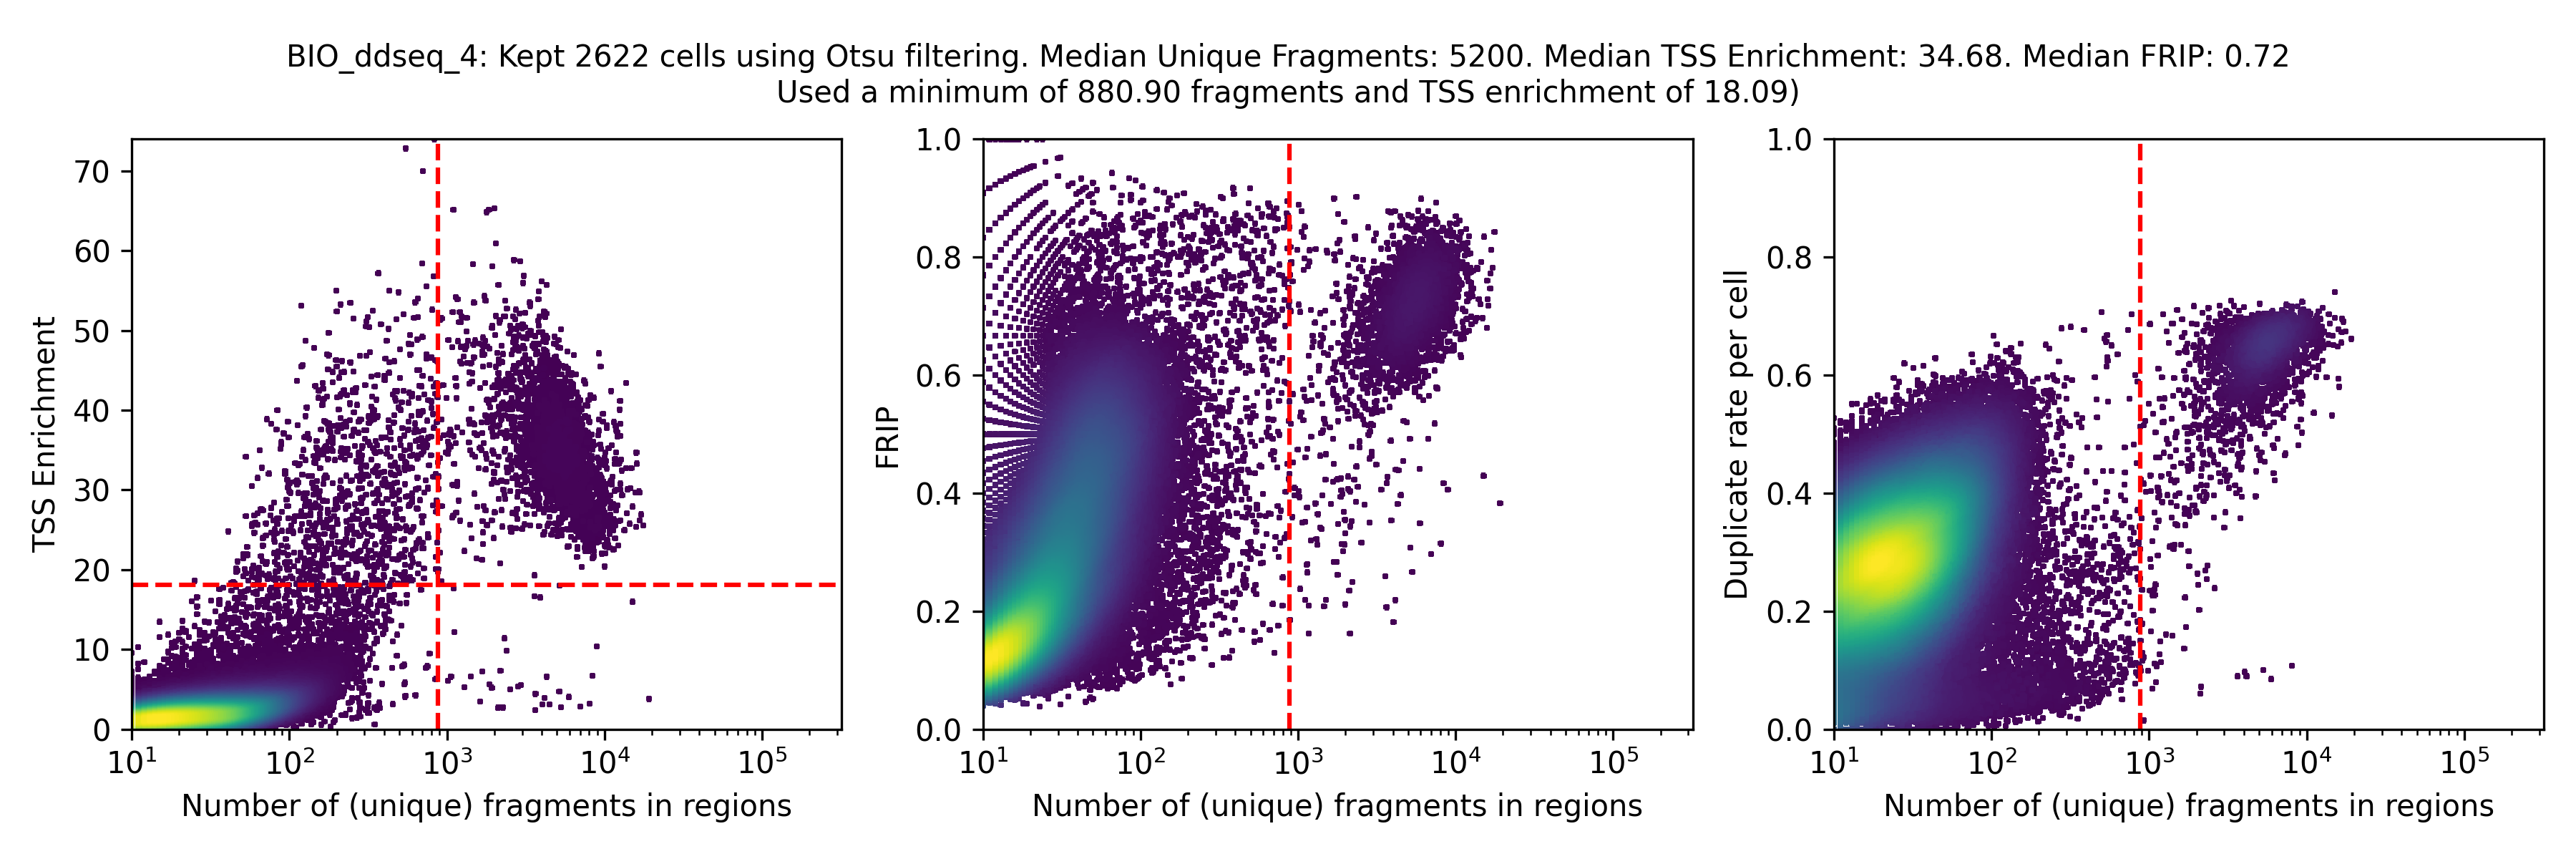

plots_qc/EPF_hydrop_1_qc_otsu.png exists, skipping...


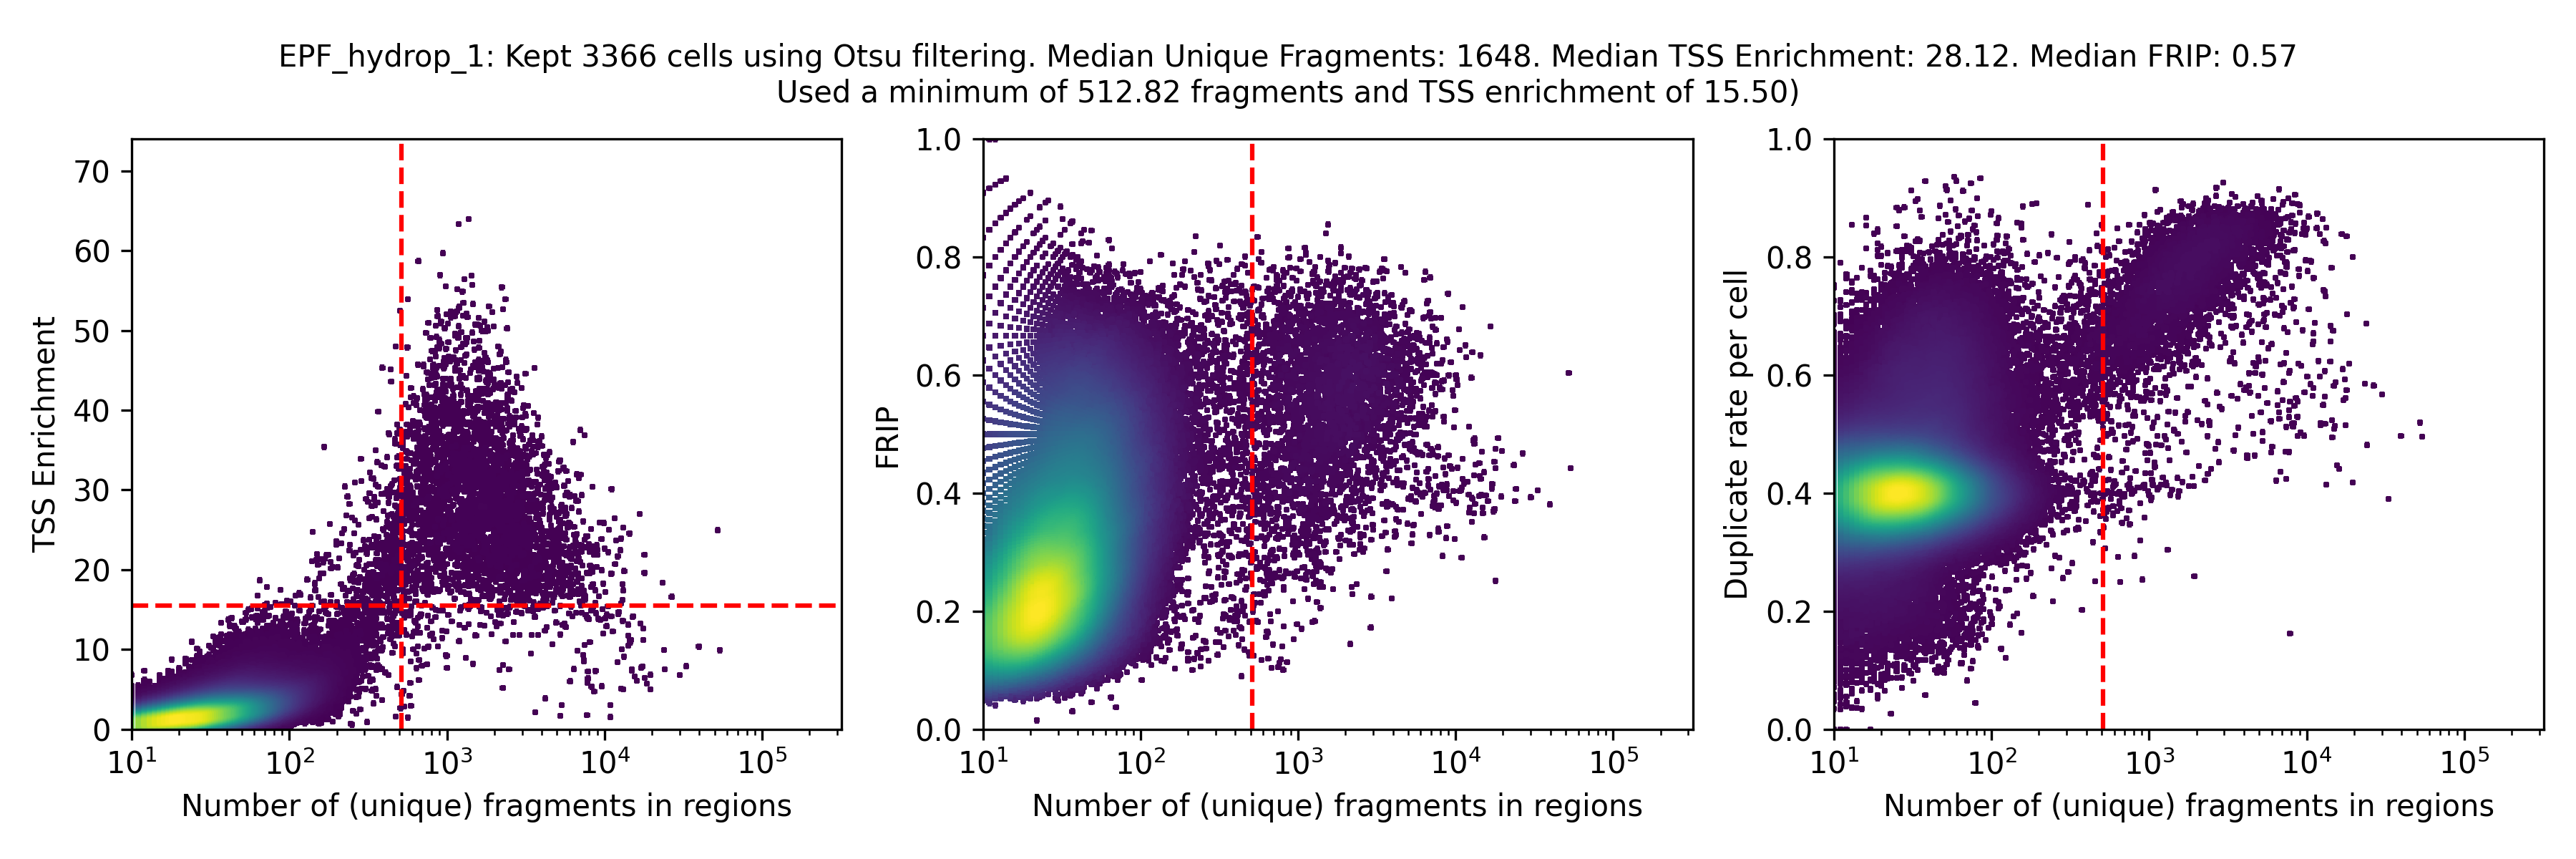

plots_qc/OHS_s3atac_1_qc_otsu.png exists, skipping...


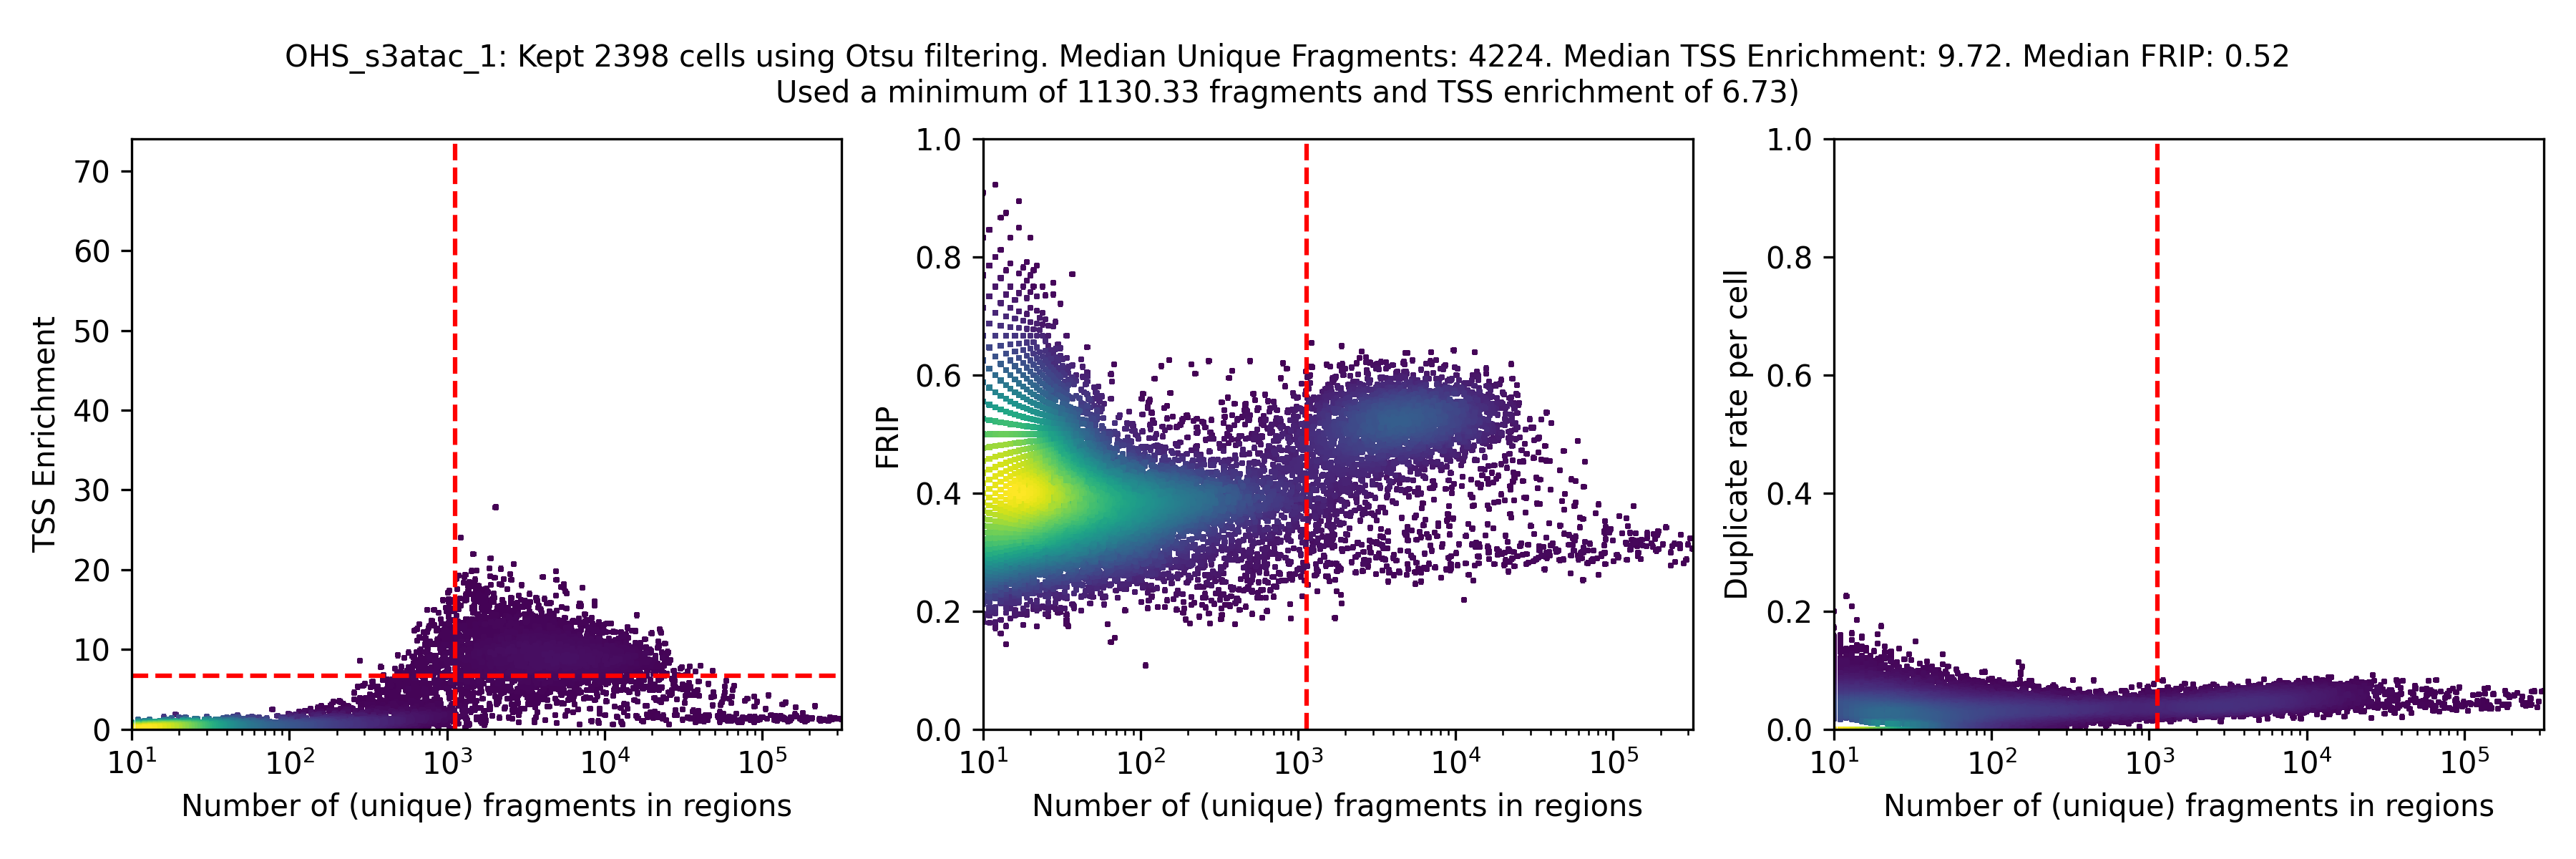

plots_qc/VIB_10xv2_1_qc_otsu.png exists, skipping...


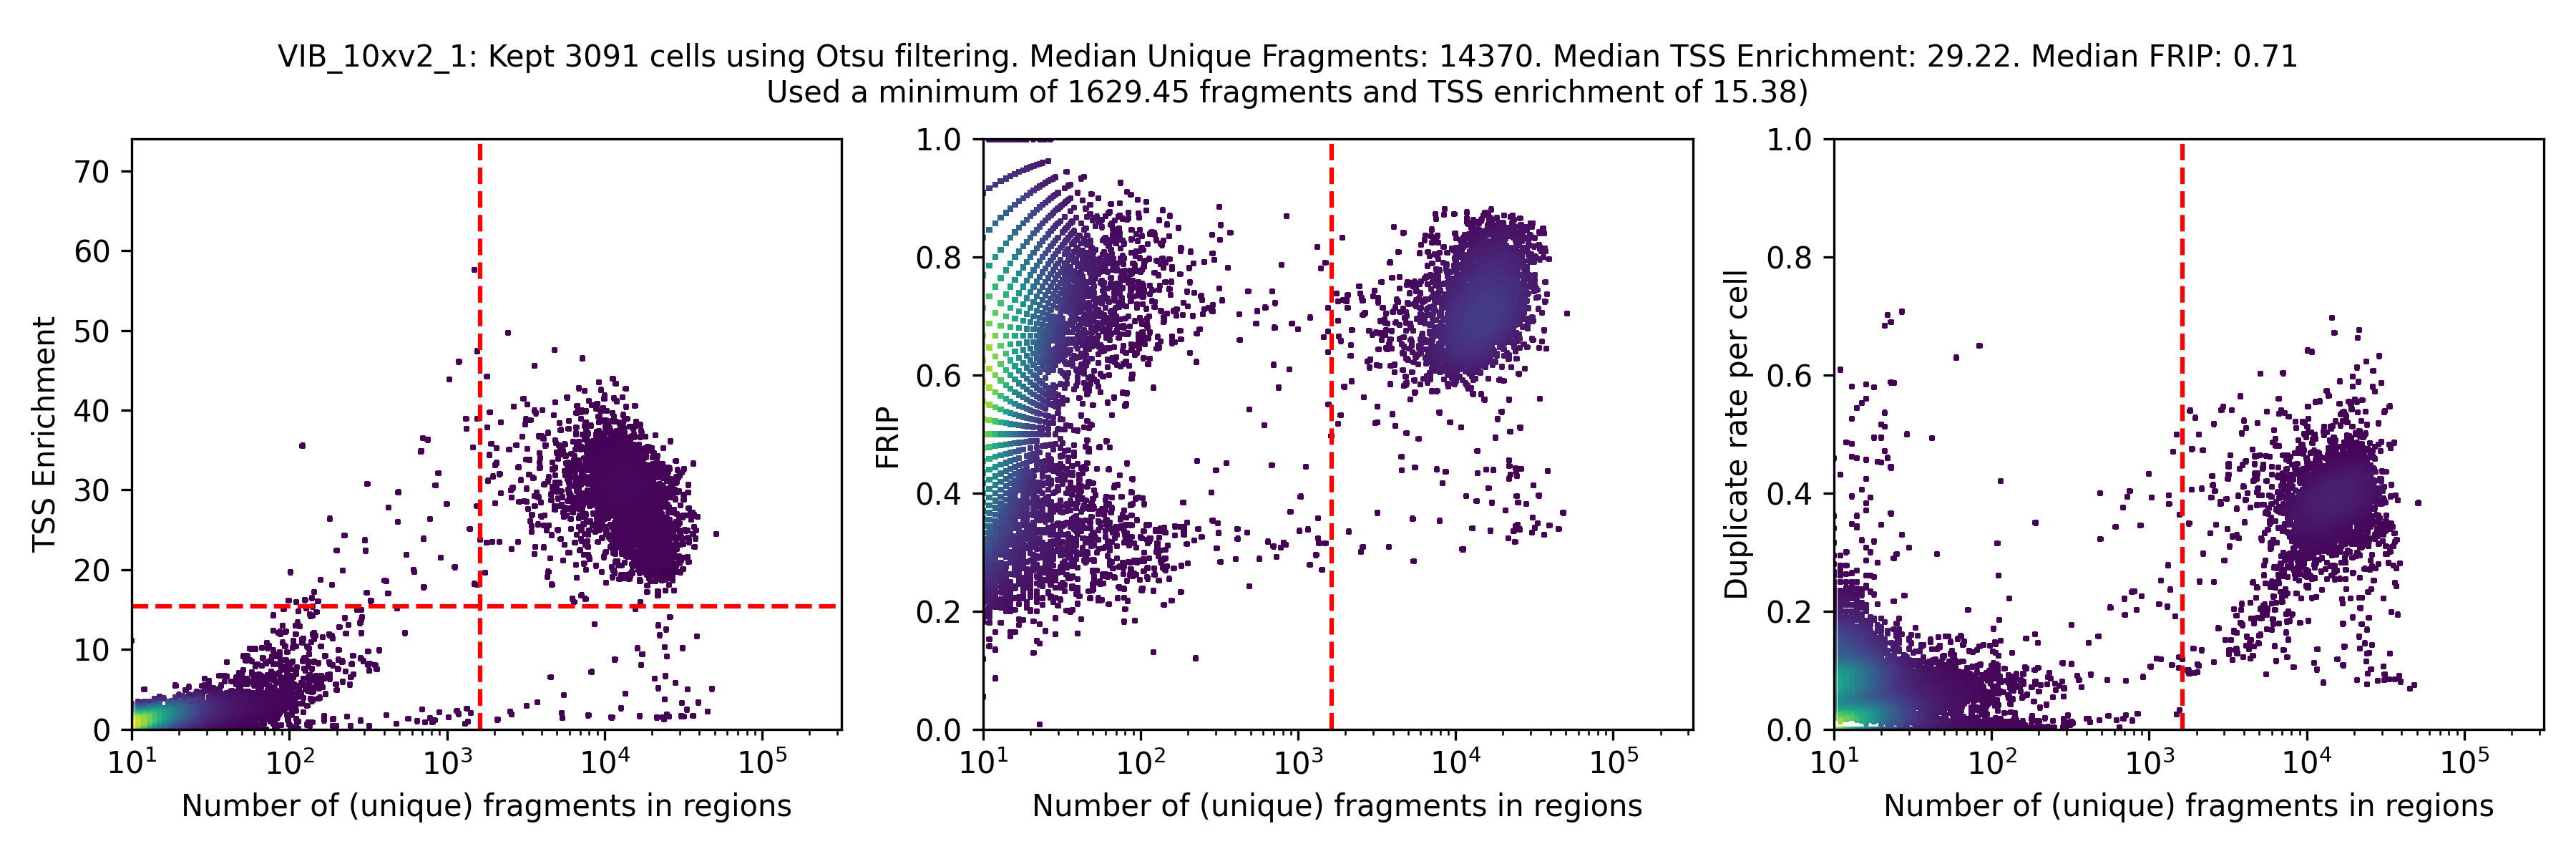

In [43]:
for sample in samples:
    out_path = f"plots_qc/{sample}_qc_otsu.png"
    if os.path.exists(out_path):
        print(f"{out_path} exists, skipping...")
        display(Image(filename=out_path))

    else:
        print(f"{out_path} does not exist yet, generating...")
        print(f"\tLoading {metadata_bc_pkl_path_dict[sample]}")
        with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
            metadata_bc_df = pickle.load(fh)

        fig = pum.plot_qc(
            sample=sample,
            sample_alias=alias_dict[sample],
            bc_passing_filters=bc_dict[sample],
            x_thresh=x_threshold_dict[sample],
            y_thresh=y_threshold_dict[sample],
            metadata_bc_df=metadata_bc_df,
            max_dict=max_dict,
            min_dict=min_dict,
            include_kde=kde,
        )

        plt.tight_layout()
        plt.savefig(out_path, dpi=300, facecolor="white")
        plt.show()
        plt.close()

### 2c. Custom thresholds for cell calling
If you're not happy with the Otsu thresholds, you can also specify your own thresholds here and replot (and re-write selected barcodes if `overwrite` is set to True:

In [44]:
overwrite = False  # whether or not to overwrite the Otsu picked barcode thresholds

In [45]:
if overwrite == True:
    x_threshold_dict = {
        "BIO_ddseq_4": 880.9013179910396,
        "EPF_hydrop_1": 512.8225812881808,
        "OHS_s3atac_1": 1130.3324161297255,
        "TEW__18d159__fe5107__Multiome_Liver_CCL4": 1109.7348164587772,
        "TEW__703a9e__28aa75__Multiome_Liver_CTRL": 1339.072241917048,
        "VIB_10xv2_1": 1629.450496987467,
    }

In [46]:
if overwrite == True:
    y_threshold_dict = {
        "BIO_ddseq_4": 18.085848066894442,
        "EPF_hydrop_1": 15.497339463079687,
        "OHS_s3atac_1": 6.72718525345622,
        "TEW__18d159__fe5107__Multiome_Liver_CCL4": 12.230333229702804,
        "TEW__703a9e__28aa75__Multiome_Liver_CTRL": 11.130604019898536,
        "VIB_10xv2_1": 15.379978138719526,
    }

In [47]:
if overwrite == True:
    bc_dict = {}
    n_bc_dict = {}

    for sample in samples:
        with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
            metadata_bc_df = pickle.load(fh)

        # calculate cells passing filter
        x_threshold = x_threshold_dict[sample]
        y_threshold = y_threshold_dict[sample]

        metadata_bc_df_passing_filters = metadata_bc_df.loc[
            (metadata_bc_df.Unique_nr_frag_in_regions > x_threshold)
            & (metadata_bc_df.TSS_enrichment > y_threshold)
        ]
        bc_passing_filters = metadata_bc_df_passing_filters.index
        bc_dict[sample] = bc_passing_filters
        n_bc_dict[sample] = len(bc_passing_filters)

        print(f"\tSaving...")
        with open(
            f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl", "wb"
        ) as fh:
            pickle.dump(bc_passing_filters, fh)
        fh.close()

        fh = open(f"selected_barcodes/{sample}_bc_passing_filters_otsu.txt", "w")
        for bc in list(bc_passing_filters):
            fh.write(bc + "\n")
        fh.close()

        metadata_bc_df.loc[bc_passing_filters].to_csv(
            f"selected_barcodes/{sample}_metadata_bc_df.tsv", sep="\t"
        )

Then, if you like, you can re-make the QC plots with your new thresholds.

In [48]:
if overwrite == True:
    for sample in samples:
        print(f"{out_path} does not exist yet, generating...")
        print(f"\tLoading {metadata_bc_pkl_path_dict[sample]}")
        with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
            metadata_bc_df = pickle.load(fh)

        fig = pum.plot_qc(
            sample=sample,
            sample_alias=alias_dict[sample],
            bc_passing_filters=bc_dict[sample],
            x_thresh=x_threshold_dict[sample],
            y_thresh=y_threshold_dict[sample],
            metadata_bc_pkl_path=metadata_bc_pkl_path_dict[sample],
            max_dict=max_dict,
            min_dict=min_dict,
            include_kde=kde,
        )

        plt.tight_layout()
        plt.savefig(out_path, dpi=300, facecolor="white")
        plt.show()
        plt.close()

### 2d. Plot combined figures
Now, we can combine all QC plots into one plot per variable:

First, load the barcodes we filtered as cells. Make sure that the barcodes match the barcodes in the fragments files! Take special care to remove any suffixes or prefixes that you may have added to the barcodes. For example, cisTopic adds `__{sample}` as a suffix to each barcode:

In [49]:
selected_barcodes_dict = {}
n_cells_dict = {}
for filepath in sorted(glob.glob("selected_barcodes/*pkl")):
    sample = os.path.basename(filepath).split("_bc")[0]
    with open(filepath, "rb") as f:
        selected_barcodes = list(pickle.load(f))
    selected_barcodes = [x.split("___")[0] for x in selected_barcodes]
    newfilepath = filepath.replace(".pkl", ".RAW.txt")
    with open(newfilepath, "w") as fp:
        for item in selected_barcodes:
            fp.write("%s\n" % item)

    selected_barcodes_dict[sample] = selected_barcodes
    n_cells_dict[sample] = len(selected_barcodes)

pp.pprint(n_cells_dict)

{'BIO_ddseq_4': 2622,
 'EPF_hydrop_1': 3366,
 'OHS_s3atac_1': 2398,
 'VIB_10xv2_1': 3091}


In [50]:
n_cols = 3
n_rows = math.ceil(len(samples) / n_cols)
figheight = n_rows * 3
figwidth = n_cols * 3

	Loading cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl
	Loading cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl
	Loading cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl
	Loading cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl


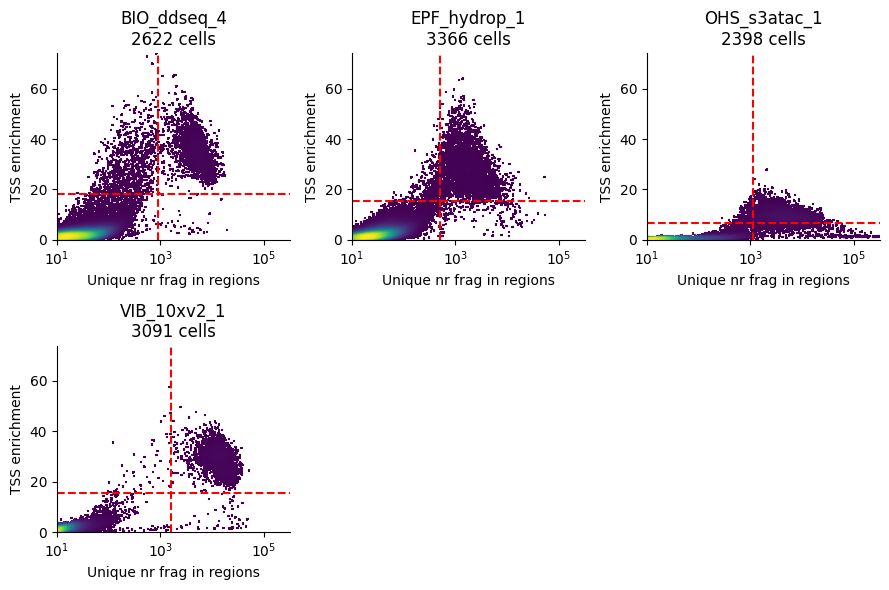

In [51]:
x_var = "Unique_nr_frag_in_regions"
y_var = "TSS_enrichment"
x_label = "Unique nr frag in regions"
y_label = "TSS enrichment"

pum.qc_mega_plot(
    metadata_bc_pkl_path_dict=metadata_bc_pkl_path_dict,
    sample_order=samples,
    n_cells_dict=n_cells_dict,
    include_kde=True,
    x_var=x_var,
    y_var=y_var,
    x_label=x_label,
    y_label=y_label,
    x_threshold_dict=x_threshold_dict,
    y_threshold_dict=y_threshold_dict,
    min_dict=min_dict,
    max_dict=max_dict,
    alias_dict=alias_dict,
    n_cols=n_cols,
    figheight=figheight,
    figwidth=figwidth,
)

plt.savefig(f"plots_qc/all_{x_var}__{y_var}.png", dpi=600)

	Loading cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl
	Loading cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl
	Loading cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl
	Loading cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl


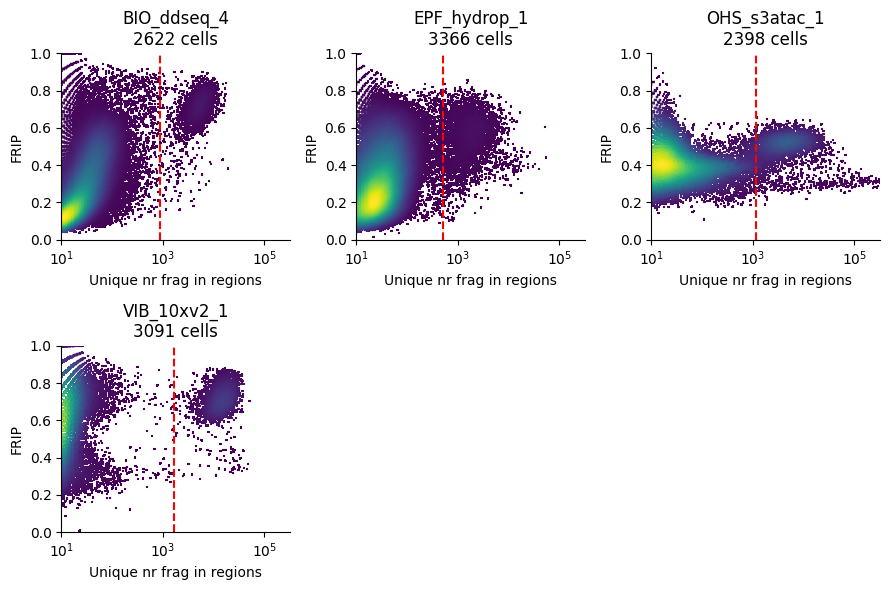

In [52]:
x_var = "Unique_nr_frag_in_regions"
y_var = "FRIP"
x_label = "Unique nr frag in regions"
y_label = "FRIP"

pum.qc_mega_plot(
    metadata_bc_pkl_path_dict=metadata_bc_pkl_path_dict,
    sample_order=samples,
    n_cells_dict=n_cells_dict,
    include_kde=True,
    x_var=x_var,
    y_var=y_var,
    x_label=x_label,
    y_label=y_label,
    x_threshold_dict=x_threshold_dict,
    y_threshold_dict=y_threshold_dict,
    min_dict=min_dict,
    max_dict=max_dict,
    alias_dict=alias_dict,
    n_cols=n_cols,
    figheight=figheight,
    figwidth=figwidth,
)

plt.savefig(f"plots_qc/all_{x_var}__{y_var}.png", dpi=600)

### 2e. Plot profile data
The following plots deal with the average accessibility profiles.

In [53]:
profile_data_pkl_path_dict = {
    os.path.basename(x).split("__profile_data.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*__profile_data.pkl"))
}
profile_data_pkl_path_dict

{'BIO_ddseq_4': 'cistopic_qc_out/BIO_ddseq_4__profile_data.pkl',
 'EPF_hydrop_1': 'cistopic_qc_out/EPF_hydrop_1__profile_data.pkl',
 'OHS_s3atac_1': 'cistopic_qc_out/OHS_s3atac_1__profile_data.pkl',
 'VIB_10xv2_1': 'cistopic_qc_out/VIB_10xv2_1__profile_data.pkl'}

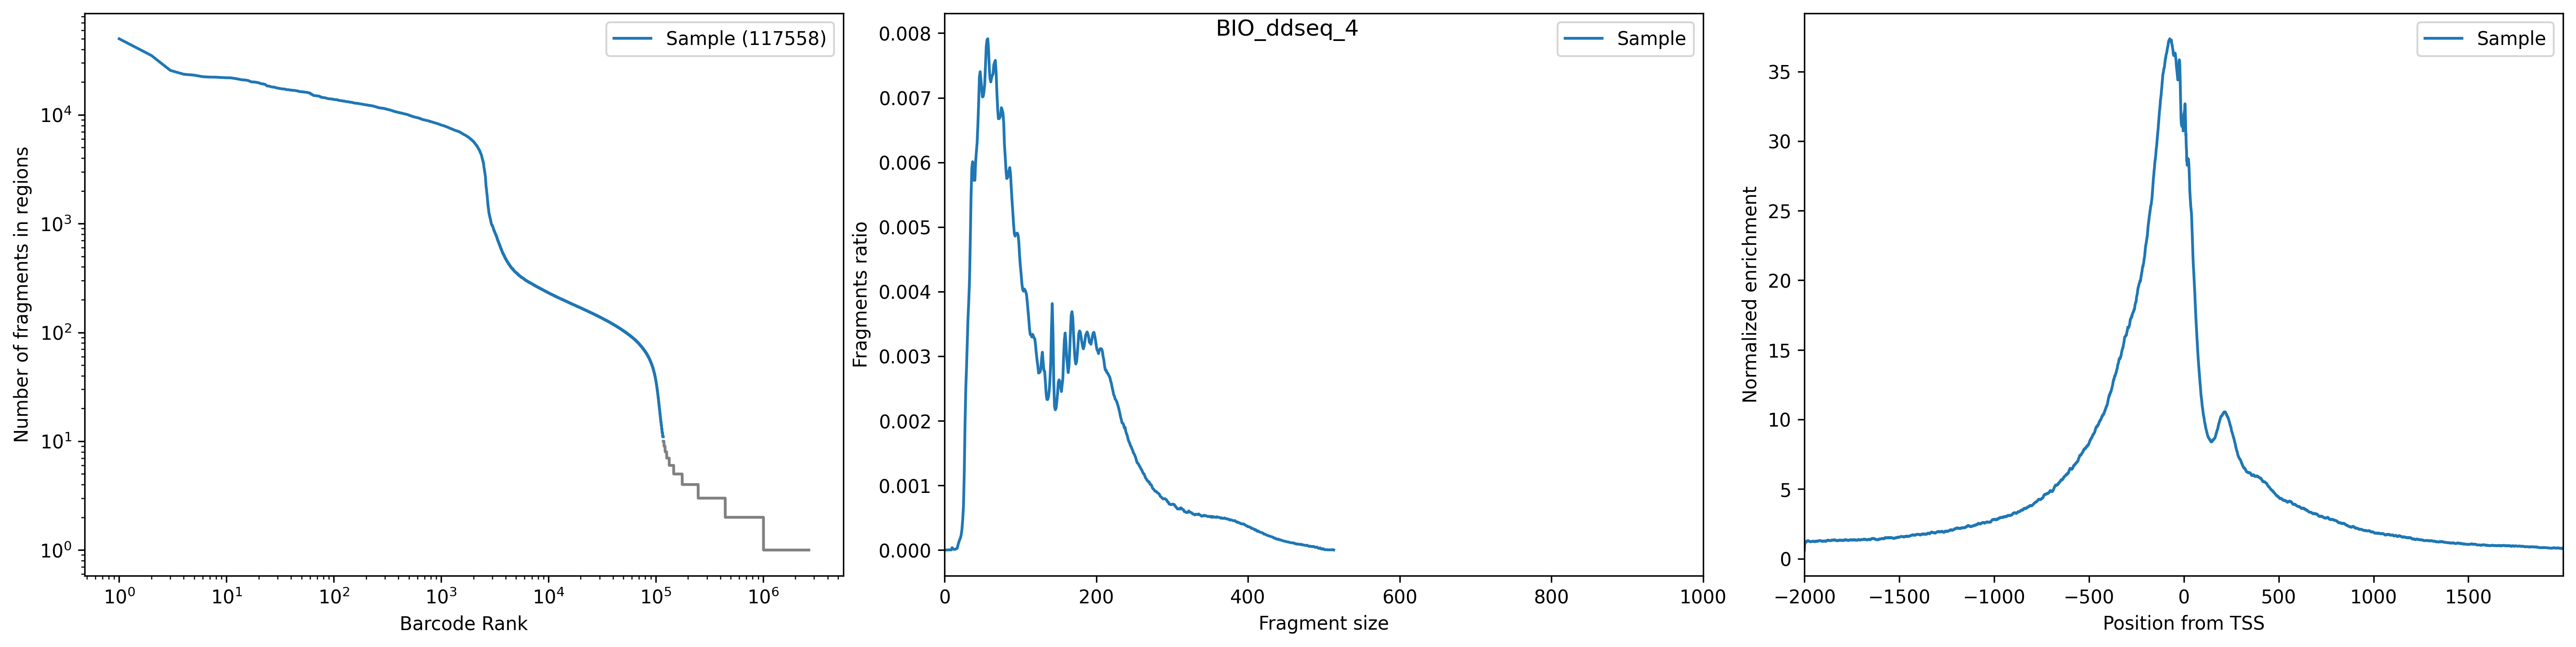

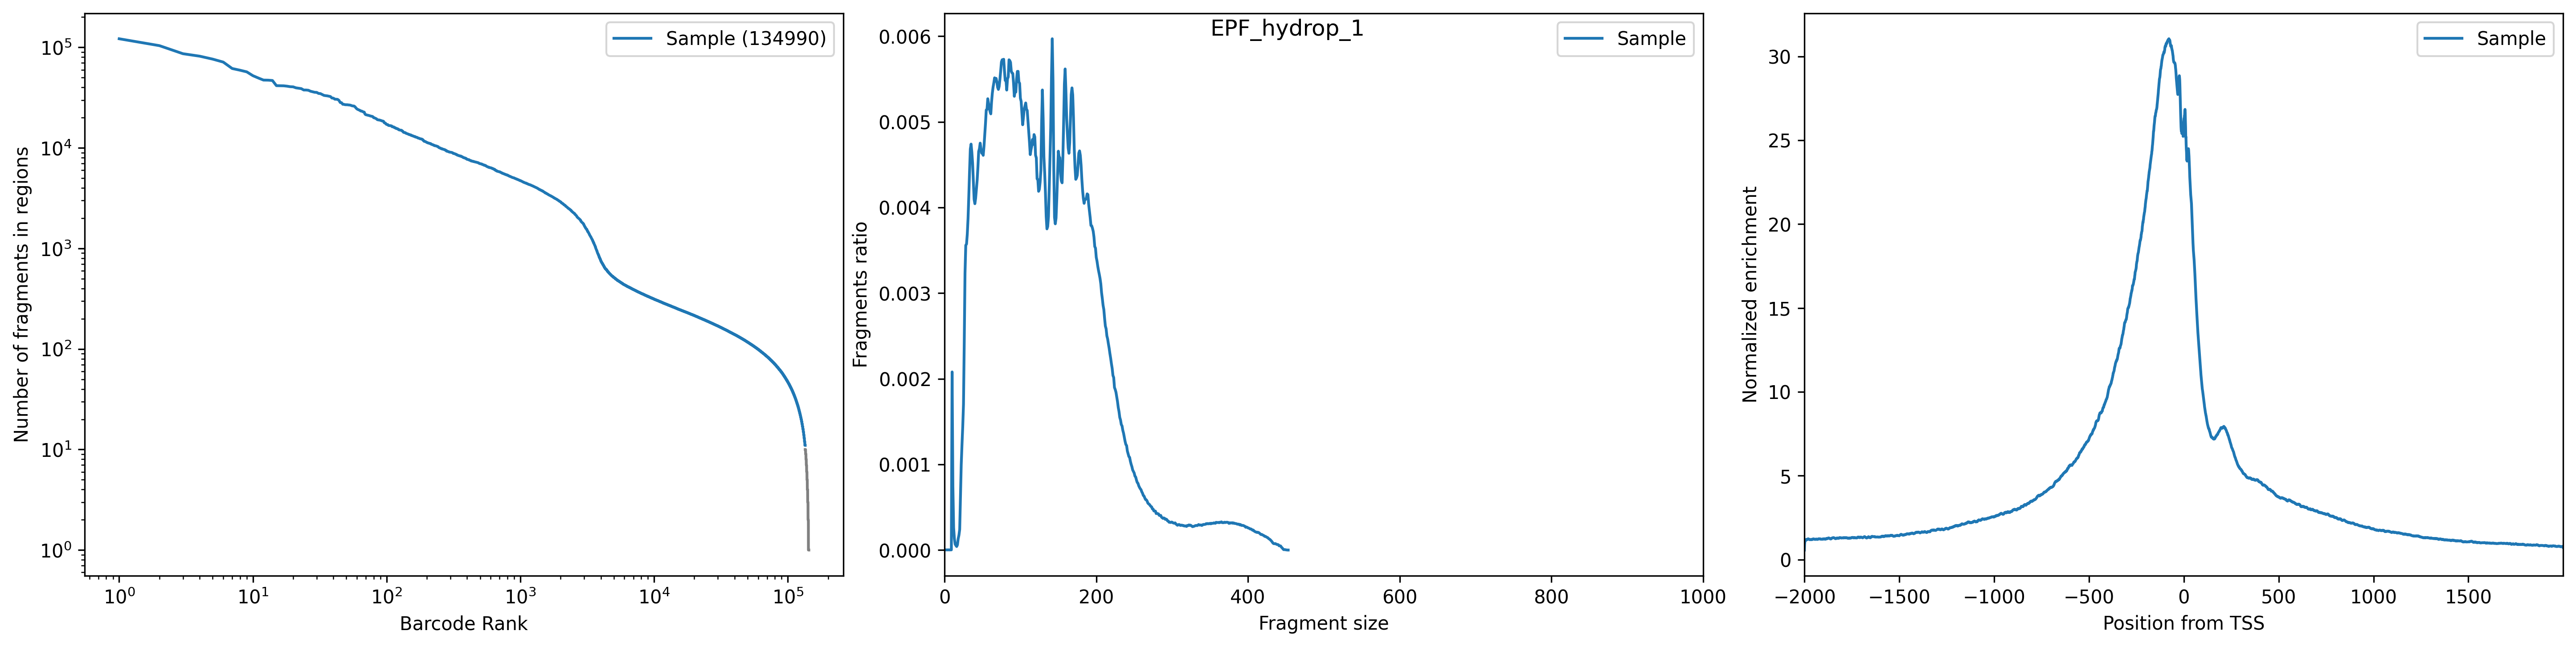

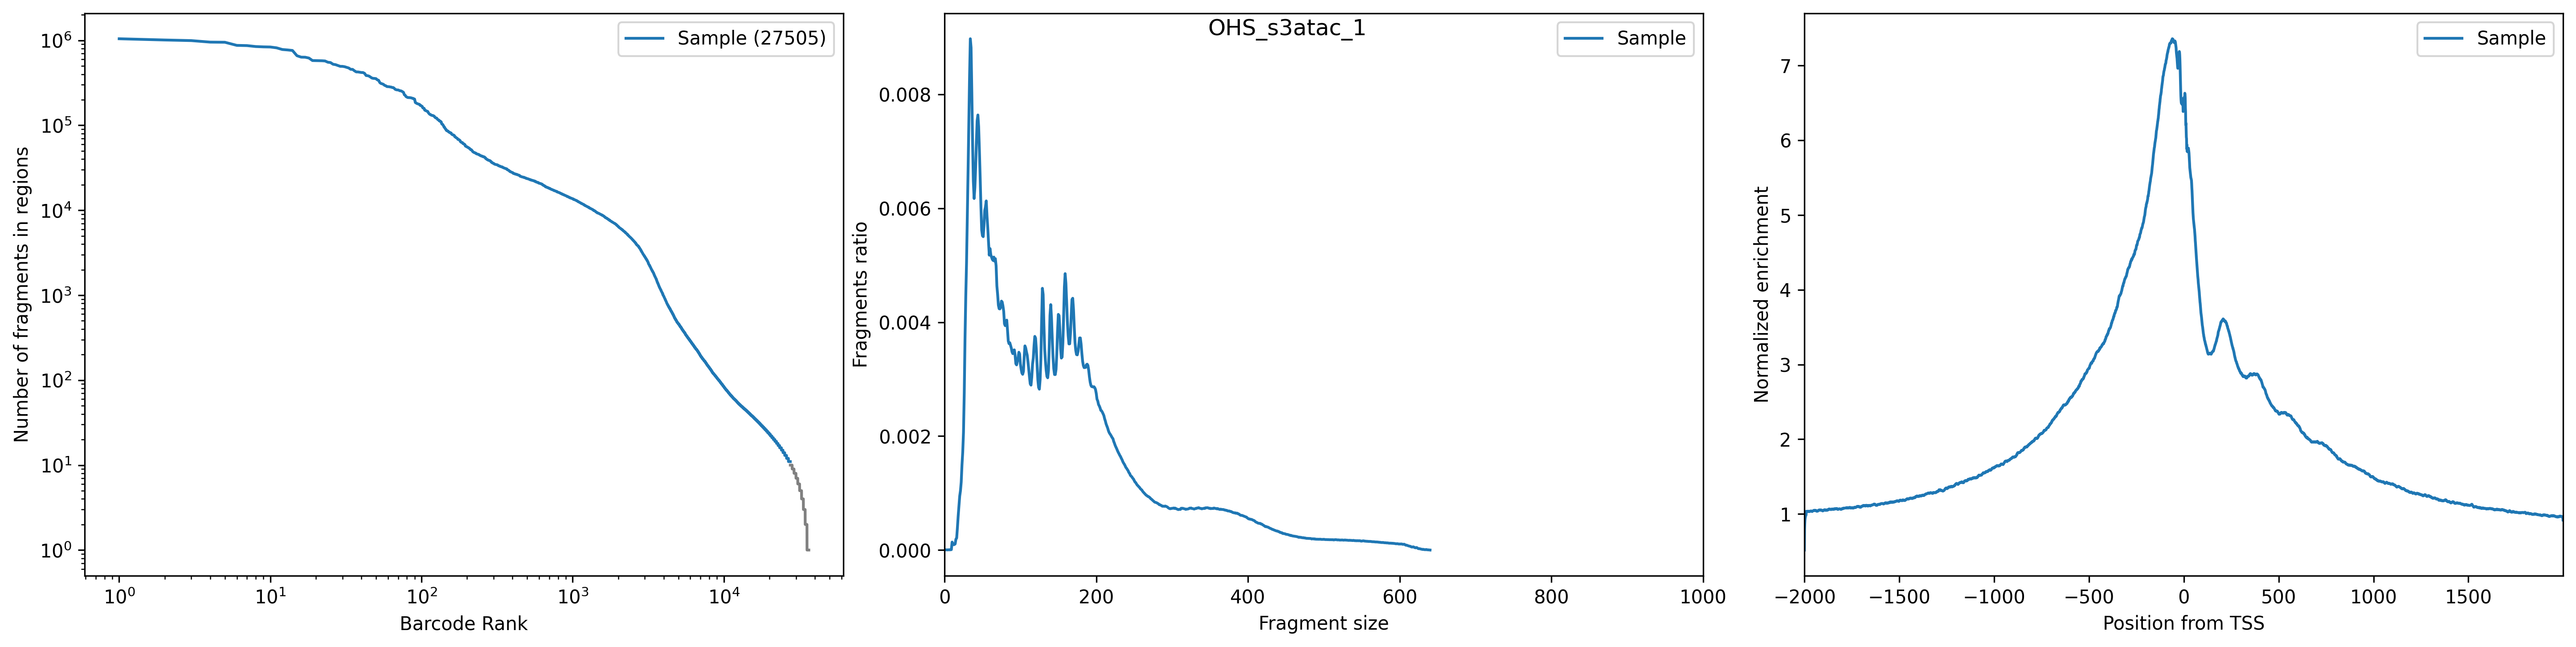

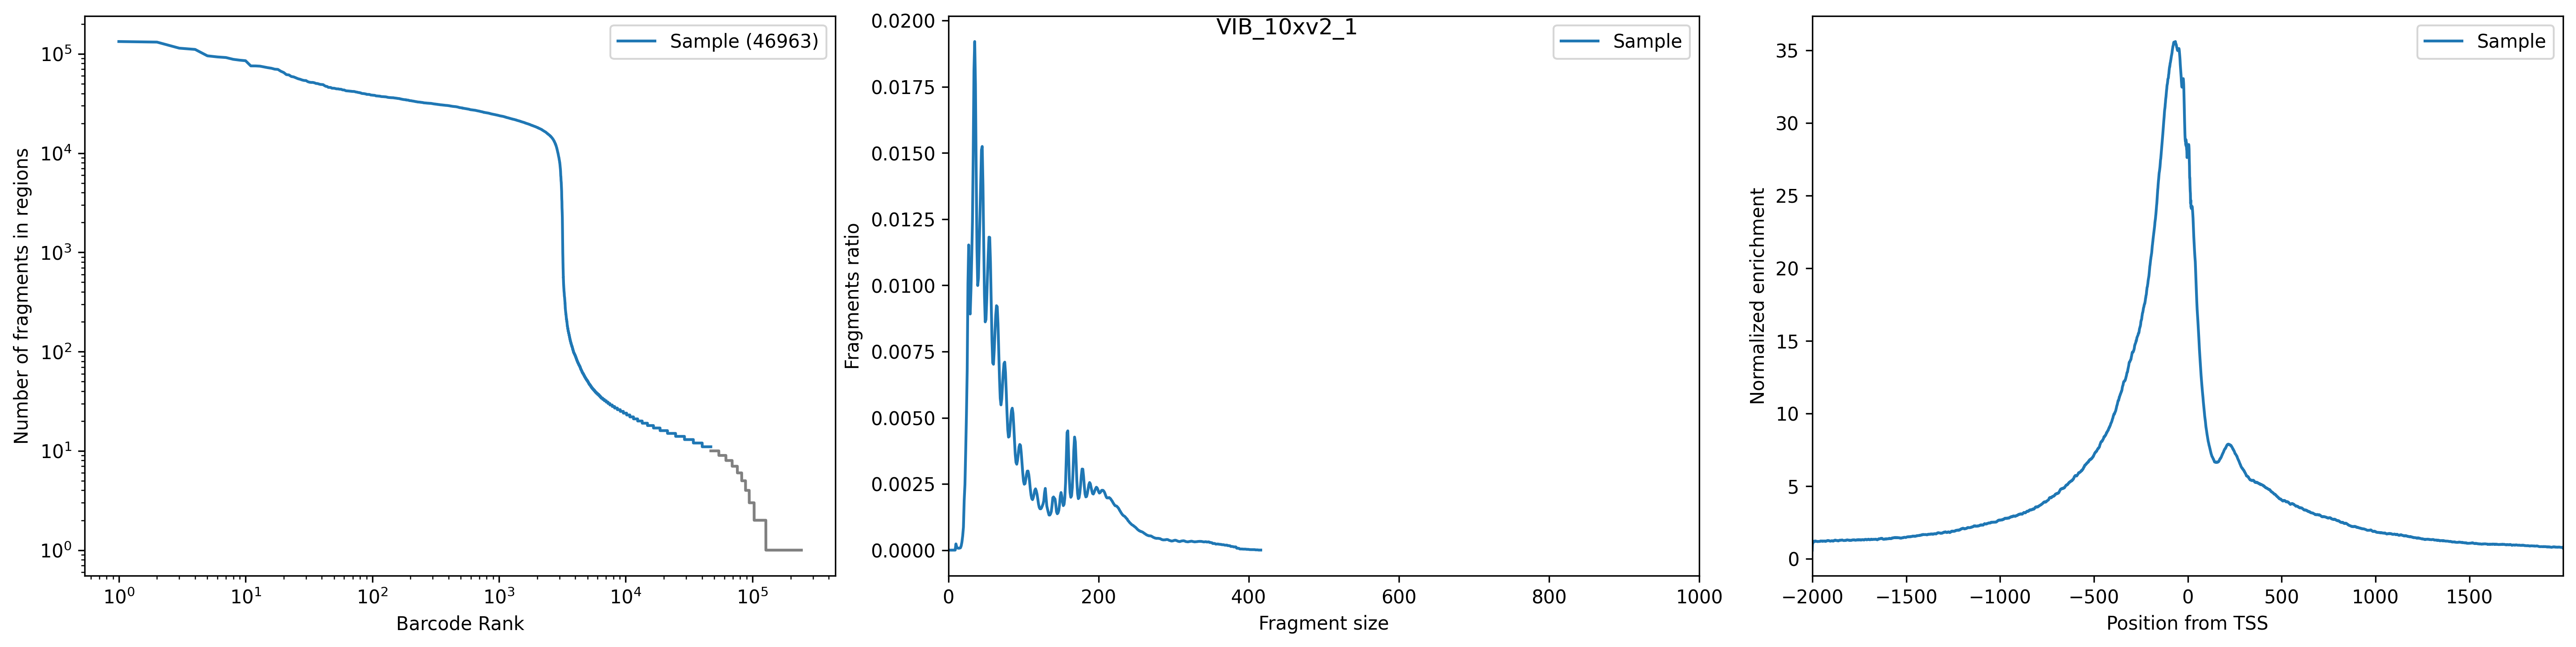

In [54]:
for sample in samples:
    path = profile_data_pkl_path_dict[sample]
    if not os.path.exists(f"plots_qc/{sample}_profile_metrics.png"):
        with open(path, "rb") as fh:
            profile_data_dict = pickle.load(fh)
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            plot_sample_metrics(
                profile_data_dict,
                ncol=3,
                plot=True,
                profile_list=[
                    "barcode_rank_plot",
                    "insert_size_distribution",
                    "profile_tss",
                ],
                insert_size_distriubtion_xlim=[0, 1000],
            )
            plt.suptitle(alias_dict[sample])
            plt.savefig(
                fname=f"plots_qc/{sample}_profile_metrics.png",
                dpi=300,
                bbox_inches="tight",
                facecolor="white",
            )
            plt.show()
    else:
        display(Image(filename=f"plots_qc/{sample}_profile_metrics.png"))

# 3. QC overview
### 3a. Gathering stats from pipeline output and cisTopic
Here, we are parsing information from several sources to make the plots below.

In [55]:
selected_barcodes_path_dict = {
    os.path.basename(x).split("_bc_passing_filters_otsu.txt")[0]: x
    for x in glob.glob("selected_barcodes/*_bc_passing_filters_otsu.txt")
}
selected_barcodes_path_dict

{'EPF_hydrop_1': 'selected_barcodes/EPF_hydrop_1_bc_passing_filters_otsu.txt',
 'BIO_ddseq_4': 'selected_barcodes/BIO_ddseq_4_bc_passing_filters_otsu.txt',
 'OHS_s3atac_1': 'selected_barcodes/OHS_s3atac_1_bc_passing_filters_otsu.txt',
 'VIB_10xv2_1': 'selected_barcodes/VIB_10xv2_1_bc_passing_filters_otsu.txt'}

In [56]:
df_stats = pum.scrape_mapping_stats(
    pumatac_output_dir=pumatac_output_dir,
    cr_output_dir=cr_output_dir,
    selected_barcodes_path_dict=selected_barcodes_path_dict,
    pipeline_dict=pipeline_dict,
    verbose=True,
)
df_stats

loading barcode stats files: ['PUMATAC_tutorial_out/data/reports/barcode/BIO_ddseq_4.corrected.bc_stats.log']
loading mapping stats files: ['PUMATAC_tutorial_out/data/reports/mapping_stats/BIO_ddseq_4_____R1.mapping_stats.tsv']
read 1 length: 54
read 2 length: 40
average map quality: 31.4
percent mapq30: 87.26
insert size average: 129.1
-------------------------------------

loading barcode stats files: ['PUMATAC_tutorial_out/data/reports/barcode/EPF_hydrop_1.corrected.bc_stats.log']
loading mapping stats files: ['PUMATAC_tutorial_out/data/reports/mapping_stats/EPF_hydrop_1_____R1.mapping_stats.tsv']
read 1 length: 49
read 2 length: 48
average map quality: 32.7
percent mapq30: 83.4
insert size average: 131.2
-------------------------------------

loading barcode stats files: ['PUMATAC_tutorial_out/data/reports/barcode/OHS_s3atac_1.corrected.bc_stats.log']
loading mapping stats files: ['PUMATAC_tutorial_out/data/reports/mapping_stats/OHS_s3atac_1_____R1.mapping_stats.tsv']
read 1 length

sample_id  n_cells      n_reads  %_correct_barcodes   
BIO_ddseq_4    BIO_ddseq_4   2621.0  108112191.0               88.10  \
EPF_hydrop_1  EPF_hydrop_1   3365.0  132665741.0               93.66   
OHS_s3atac_1  OHS_s3atac_1   2397.0  127311784.0              100.00   
VIB_10xv2_1    VIB_10xv2_1   3090.0  126713277.0               96.20   

              r1_length  r2_length  avg_insert_size  %_mapq30  avg_map_quality  
BIO_ddseq_4        54.0       40.0            129.0     87.26             31.4  
EPF_hydrop_1       49.0       48.0            131.0     83.40             32.7  
OHS_s3atac_1       85.0       67.0            157.0     80.64             34.5  
VIB_10xv2_1        50.0       50.0            103.0     92.75             33.0

In [57]:
verbose = True

In [58]:
metadata_path_dict = {
    x.split("/")[-1].split(f"__metadata_bc.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata*pkl"))
}
if verbose:
    pp.pprint(metadata_path_dict)

{'BIO_ddseq_4': 'cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl',
 'EPF_hydrop_1': 'cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl',
 'OHS_s3atac_1': 'cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl',
 'VIB_10xv2_1': 'cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl'}


In [59]:
selected_cells_path_dict = {
    x.split("/")[-1].split(f"_bc_passing_filters_otsu.pkl")[0]: x
    for x in sorted(glob.glob(f"selected_barcodes/*.pkl"))
}
if verbose:
    pp.pprint(selected_cells_path_dict)

{'BIO_ddseq_4': 'selected_barcodes/BIO_ddseq_4_bc_passing_filters_otsu.pkl',
 'EPF_hydrop_1': 'selected_barcodes/EPF_hydrop_1_bc_passing_filters_otsu.pkl',
 'OHS_s3atac_1': 'selected_barcodes/OHS_s3atac_1_bc_passing_filters_otsu.pkl',
 'VIB_10xv2_1': 'selected_barcodes/VIB_10xv2_1_bc_passing_filters_otsu.pkl'}


Read the cisTopic output.

In [60]:
df_scstats_merged, df_stats = pum.scrape_scstats(
    metadata_path_dict, selected_cells_path_dict, df_stats
)

These are variables necessary for plotting (order of samples, color palettes, ...)

### 3b. Plotting and comparing to the 2023 benchmark.

Load the reference data from De Rop et al., 2023 and combine it with the user samples:

In [61]:
df_stats_merged = pum.calculate_losses(df_stats, df_scstats_merged)

In [62]:
sns.set_context("notebook")
sns.set_style("darkgrid")

If you want, you can change the order in which your samples are plotted by manually editing key `user_sample` in the dictionary `order_dict_tech_ultrashort`

Some variables necessary for plotting.

In [63]:
order = [
    "tech",
    "No correct barcode",
    "Not mapped properly",
    "Fragments in noise barcodes",
    "Duplicate fragments in cells",
    "Unique, in cells, not in peaks",
    "Unique, in cells, in peaks",
]

order = order[::-1]

losses_color_palette = palettable.cartocolors.qualitative.Safe_7.get_mpl_colormap()

tech_alias_dict = {
    "10xmultiome": "10x\nMultiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv11c": "10x v1.1\ncontrols",
    "10xv2": "10x v2",
    "ddseq": "Bio-Rad\nddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "mtscatacfacs": "*",
    "s3atac": "s3-ATAC",
    "user_sample": "User samples",
}

In [64]:
individual_barplot_width = 0.5
individual_plot_row_height = 4

In [65]:
tech_order = [
    "10xv1",
    "10xv11",
    "10xv11c",
    "10xv2",
    "10xmultiome",
    "user_sample",
    "mtscatac",
    "mtscatacfacs",
    "ddseq",
    "s3atac",
    "hydrop",
]

In [66]:
ylim_dict = {
    "Unique_nr_frag_in_regions": [0, 20000],
    "Unique_nr_frag_in_regions_k": [0, 20],
    "FRIP": [0, 1],
    "TSS_enrichment": [0, 45],
}

In [67]:
individual_barplot_width = 0.5
individual_plot_row_height = 4

/lustre1/project/stg_00002/lcb/fderop/data/20231115_hydrop_v2/PUMATAC_tutorial/pypumatac.py:1838: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


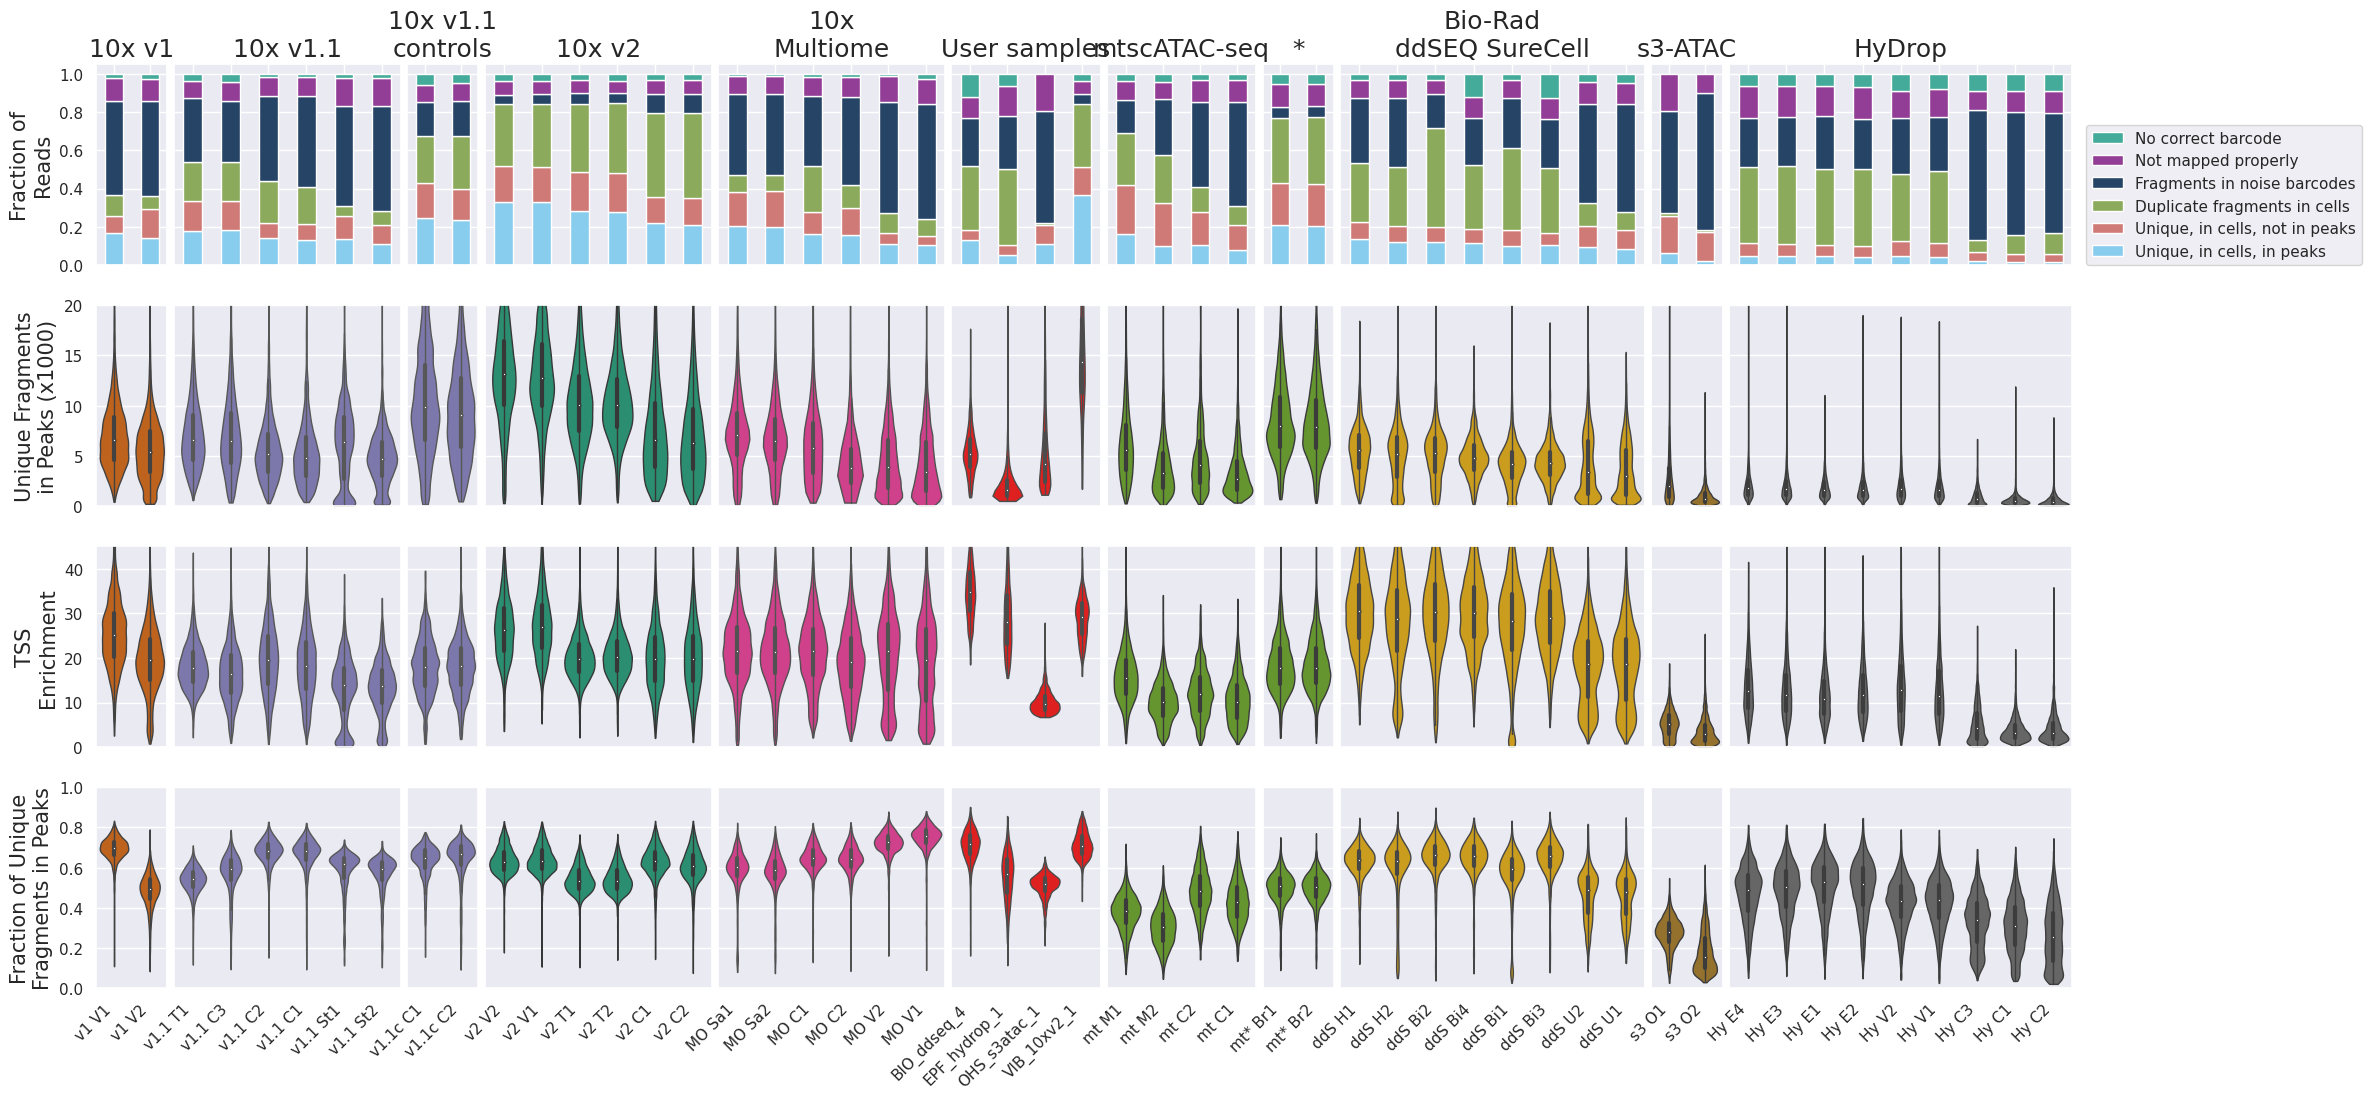

In [68]:
variables_list = ["Unique_nr_frag_in_regions_k", "TSS_enrichment", "FRIP"]

pum.plot_all_qc(
    df_stats_merged,
    df_scstats_merged,
    variables_list,
    samples,
    alias_dict,
    tech_order,
    ylim_dict,
    svg_output_path="plots_qc/all_barplots.svg",
    png_output_path="plots_qc/all_barplots.png",
)

Only the user samples:

In [69]:
ymax_frags = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["Unique_nr_frag_in_regions"]
    .median()
    .max()
    * 2
)
ymax_frags_k = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["Unique_nr_frag_in_regions_k"]
    .median()
    .max()
    * 2
)
ymax_tss = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["TSS_enrichment"]
    .median()
    .max()
    * 2
)

ylim_dict = {
    "Unique_nr_frag_in_regions": [0, ymax_frags],
    "Unique_nr_frag_in_regions_k": [0, ymax_frags_k],
    "FRIP": [0, 1],
    "TSS_enrichment": [0, ymax_tss],
}

/lustre1/project/stg_00002/lcb/fderop/data/20231115_hydrop_v2/PUMATAC_tutorial/pypumatac.py:1838: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


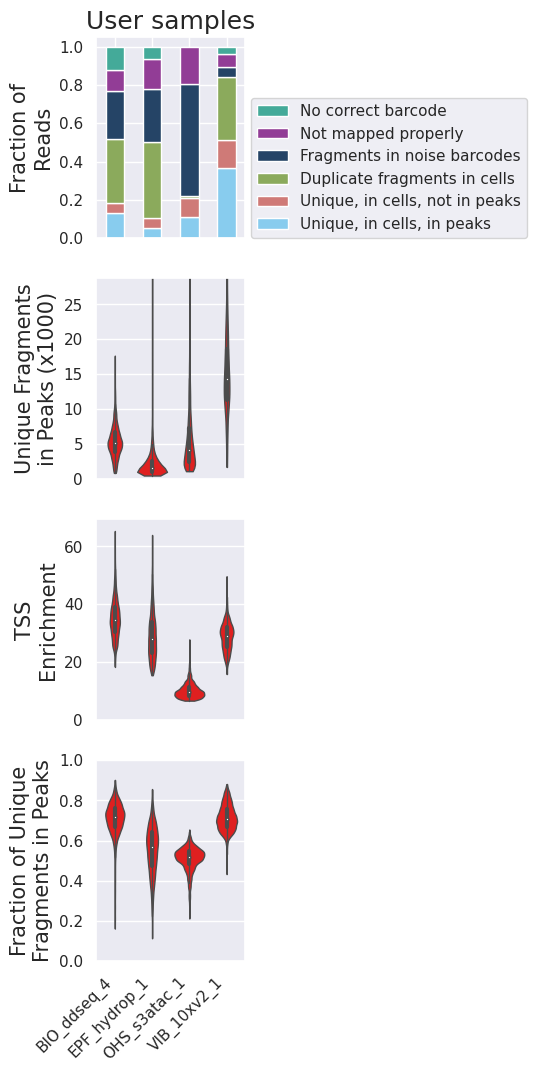

In [70]:
variables_list = ["Unique_nr_frag_in_regions_k", "TSS_enrichment", "FRIP"]

pum.plot_all_qc(
    df_stats_merged,
    df_scstats_merged,
    variables_list,
    samples,
    alias_dict,
    ["user_sample"],
    ylim_dict,
    svg_output_path="plots_qc/usersamples_barplots.svg",
    png_output_path="plots_qc/usersamples_barplots.png",
)

# 4. Saturation analysis
### 4a. Calculate the downsampling statistics
We will now downsampled the fragments files at set intervals and calculate quality metrics on these downsampled sets. Then, we will use these datapoints to fit a curve and extrapolate further sequencing saturation.  

The following code subsets the `fragments.tsv.gz` file for selected cells, and then calculates the saturation within these selected cells.

Make a directory where the saturation statistics will be written:

In [71]:
saturation_stats_path = "saturation_stats"
if not os.path.exists(saturation_stats_path):
    os.mkdir(saturation_stats_path)

Check which ones were already run:

In [72]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'VIB_10xv2_1': 'saturation_stats/VIB_10xv2_1.sampling_stats.tsv'}

Define the sampling fractions (levels to which we will downsample the fragments file and calculate saturation):

In [73]:
sampling_fractions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 1]

### 4b. Option #1: Execute the downsampling script using singularity
This is preferred in case you have many fragments files and want to parallelize

In [74]:
raw_barcode_path = {
    os.path.basename(x).split("_bc")[0]: x
    for x in sorted(glob.glob("selected_barcodes/*RAW.txt"))
}
script_path = "scripts/sub_sample_fragments.py"
sif_path = "PUMATAC_dependencies/jupyter_kernels/20230504_pycistopic.sif"
mounts = "/lustre1,/staging,/data,/vsc-hard-mounts,/scratch"

for sample in samples:
    fragments_path = fragments_path_dict[sample]
    if not sample in sampling_stats_path_dict.keys():
        command = f"singularity exec -B {mounts} {sif_path} python {script_path} -i {os.path.abspath(fragments_path)} -o {saturation_stats_path}/{sample} -c {os.path.abspath(raw_barcode_path[sample])} -s {','.join([str(x) for x in sampling_fractions])} -n {int(df_stats.at[sample, 'n_reads'])} &"

        print(command)

And call these commands in command line. `&` indicates that the command will be submitted as background job (all of them will run at once).

### 4c. Option #2. Run the function directly in this notebook:
Fastest method for a few samples.

In [75]:
covar_dict = {}
best_fit_ab_dict = {}
x_fit_dict = {}
y_fit_dict = {}
pl.enable_string_cache(True)

for sample in samples:
    print(sample)

    if not sample in sampling_stats_path_dict.keys():
        print(f"{sample} stats do not exist")

        frags_path = fragments_path_dict[sample]
        fragments_df = pum.read_bc_and_counts_from_fragments_file(frags_path)

        # Sub-sample.
        stats_df = pum.sub_sample_fragments(
            fragments_df=fragments_df,
            selected_barcodes=selected_barcodes_dict[sample],
            sampling_fractions=sampling_fractions,
            stats_tsv_filename=f"{saturation_stats_path}/{sample}.sampling_stats.tsv",
            # whitelist=args.whitelist,
            n_reads=df_stats.at[sample, "n_reads"],
        )

BIO_ddseq_4
EPF_hydrop_1
OHS_s3atac_1
VIB_10xv2_1


### 4d. Plotting the saturation
The following files should be generated:

In [76]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'VIB_10xv2_1': 'saturation_stats/VIB_10xv2_1.sampling_stats.tsv'}

First, we plot the saturation of median unique fragments per barcode. I also want to find out at which dept I reach 75% of the saturation value (plotted in blue):

In [77]:
percentage_toplot = 0.75

On the x-axis, I want to plot the mean reads per barcode (i.e. the total number of sequenced reads divided by the number of cells), on the y-axis I want the median number of unique fragments, and I also want to indicate the current saturation level (i.e. the saturation of the full, non-sampled fragments file).

I use a michaelis-menten kinetic model to fit these values.

In [78]:
def MM(x, Vmax, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Vmax > 0 and Km > 0:
        y = (Vmax * x) / (Km + x)
    else:
        y = 1e10
    return y

In the following plot, `kRPC` denotes reads per cell (thousands).

In [79]:
sns.set_style("ticks")

In [80]:
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'VIB_10xv2_1': 'saturation_stats/VIB_10xv2_1.sampling_stats.tsv'}

BIO_ddseq_4


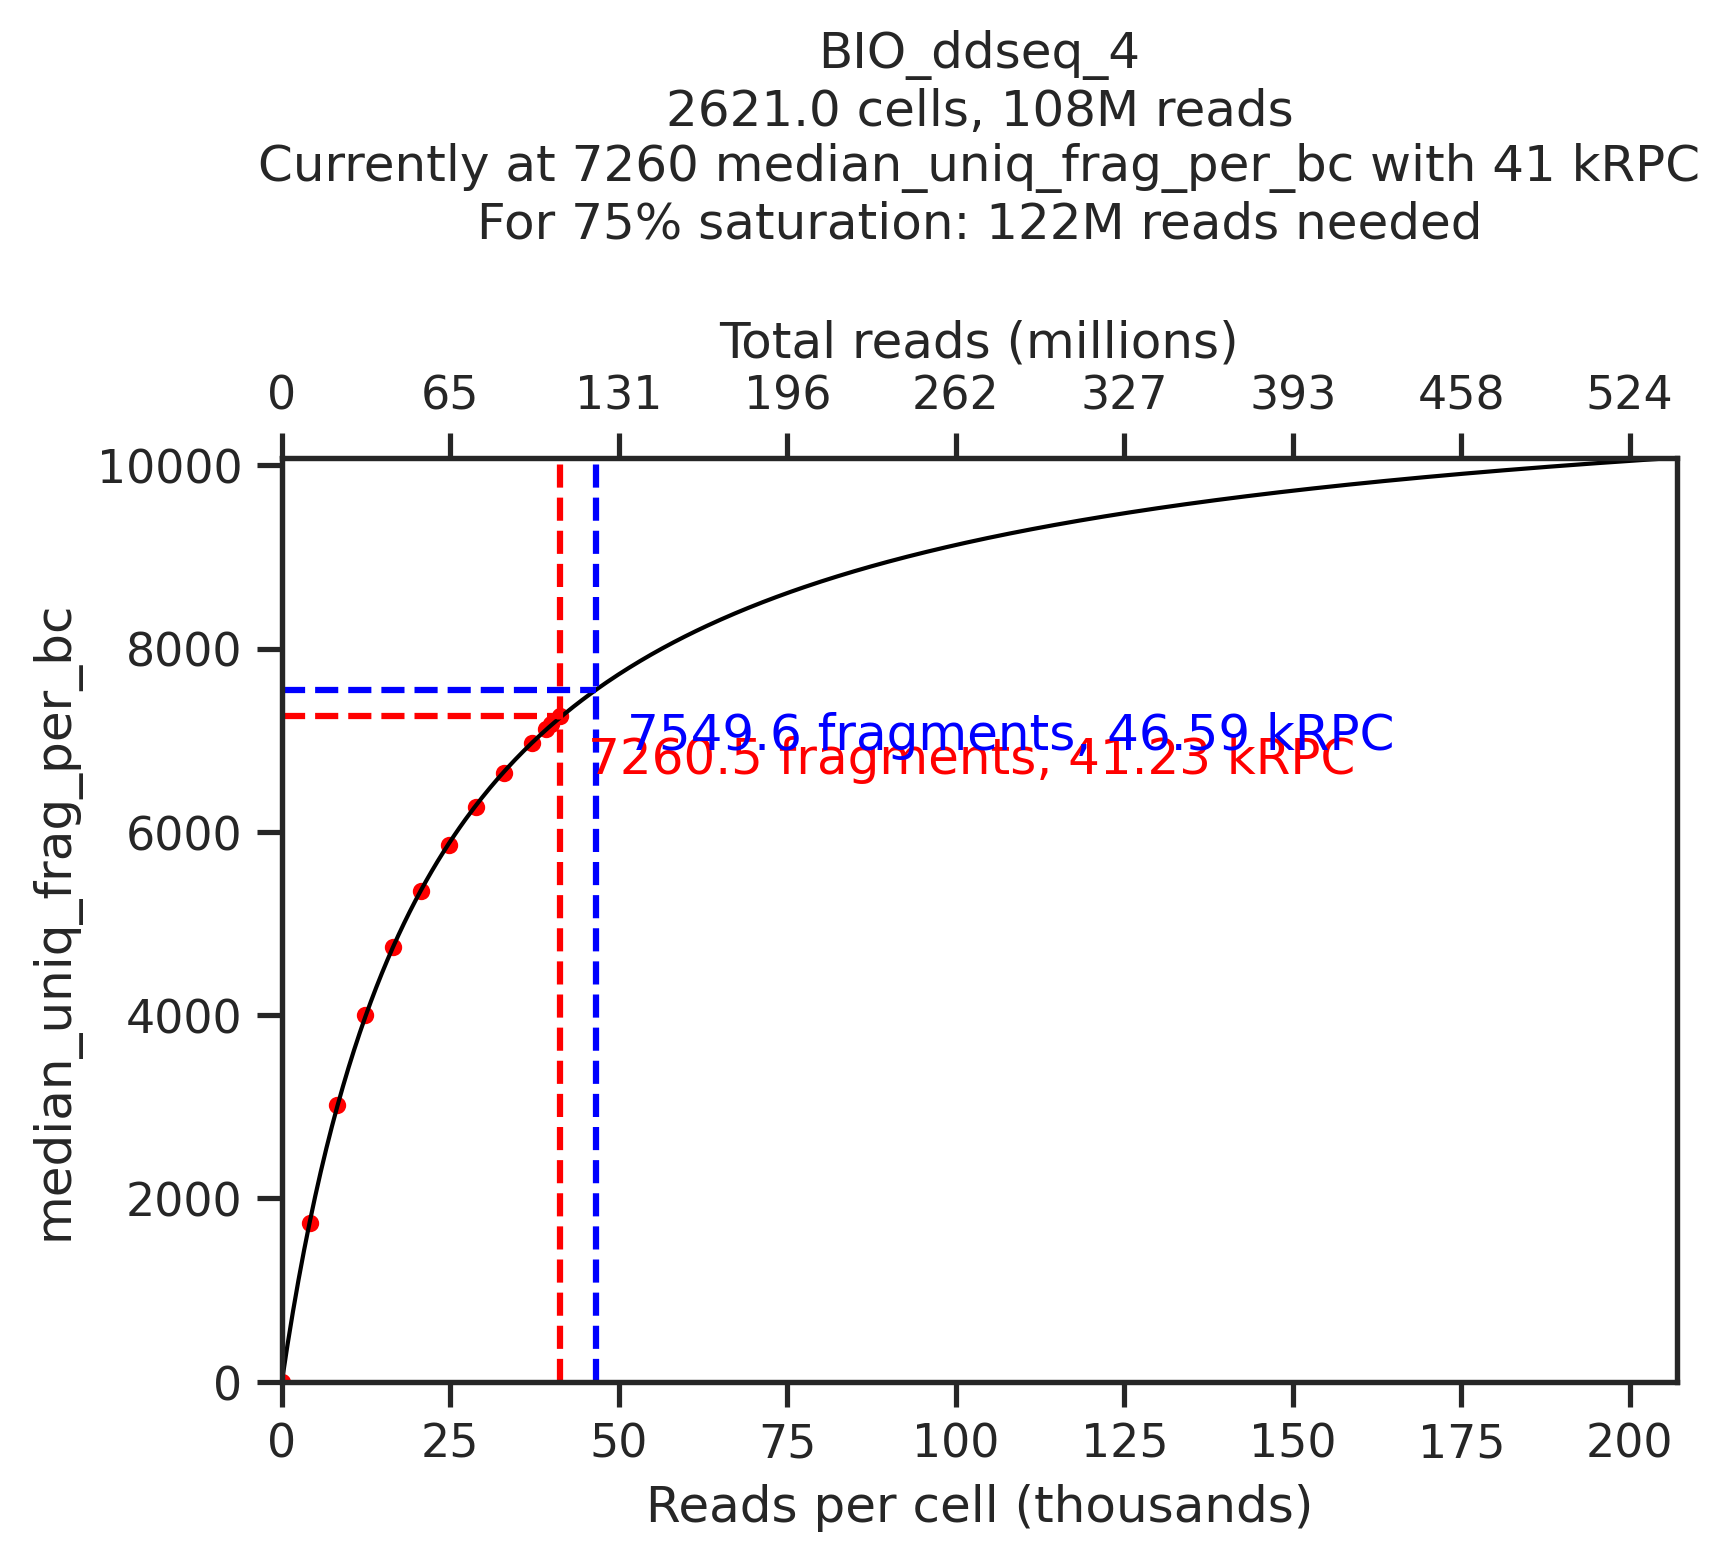

EPF_hydrop_1


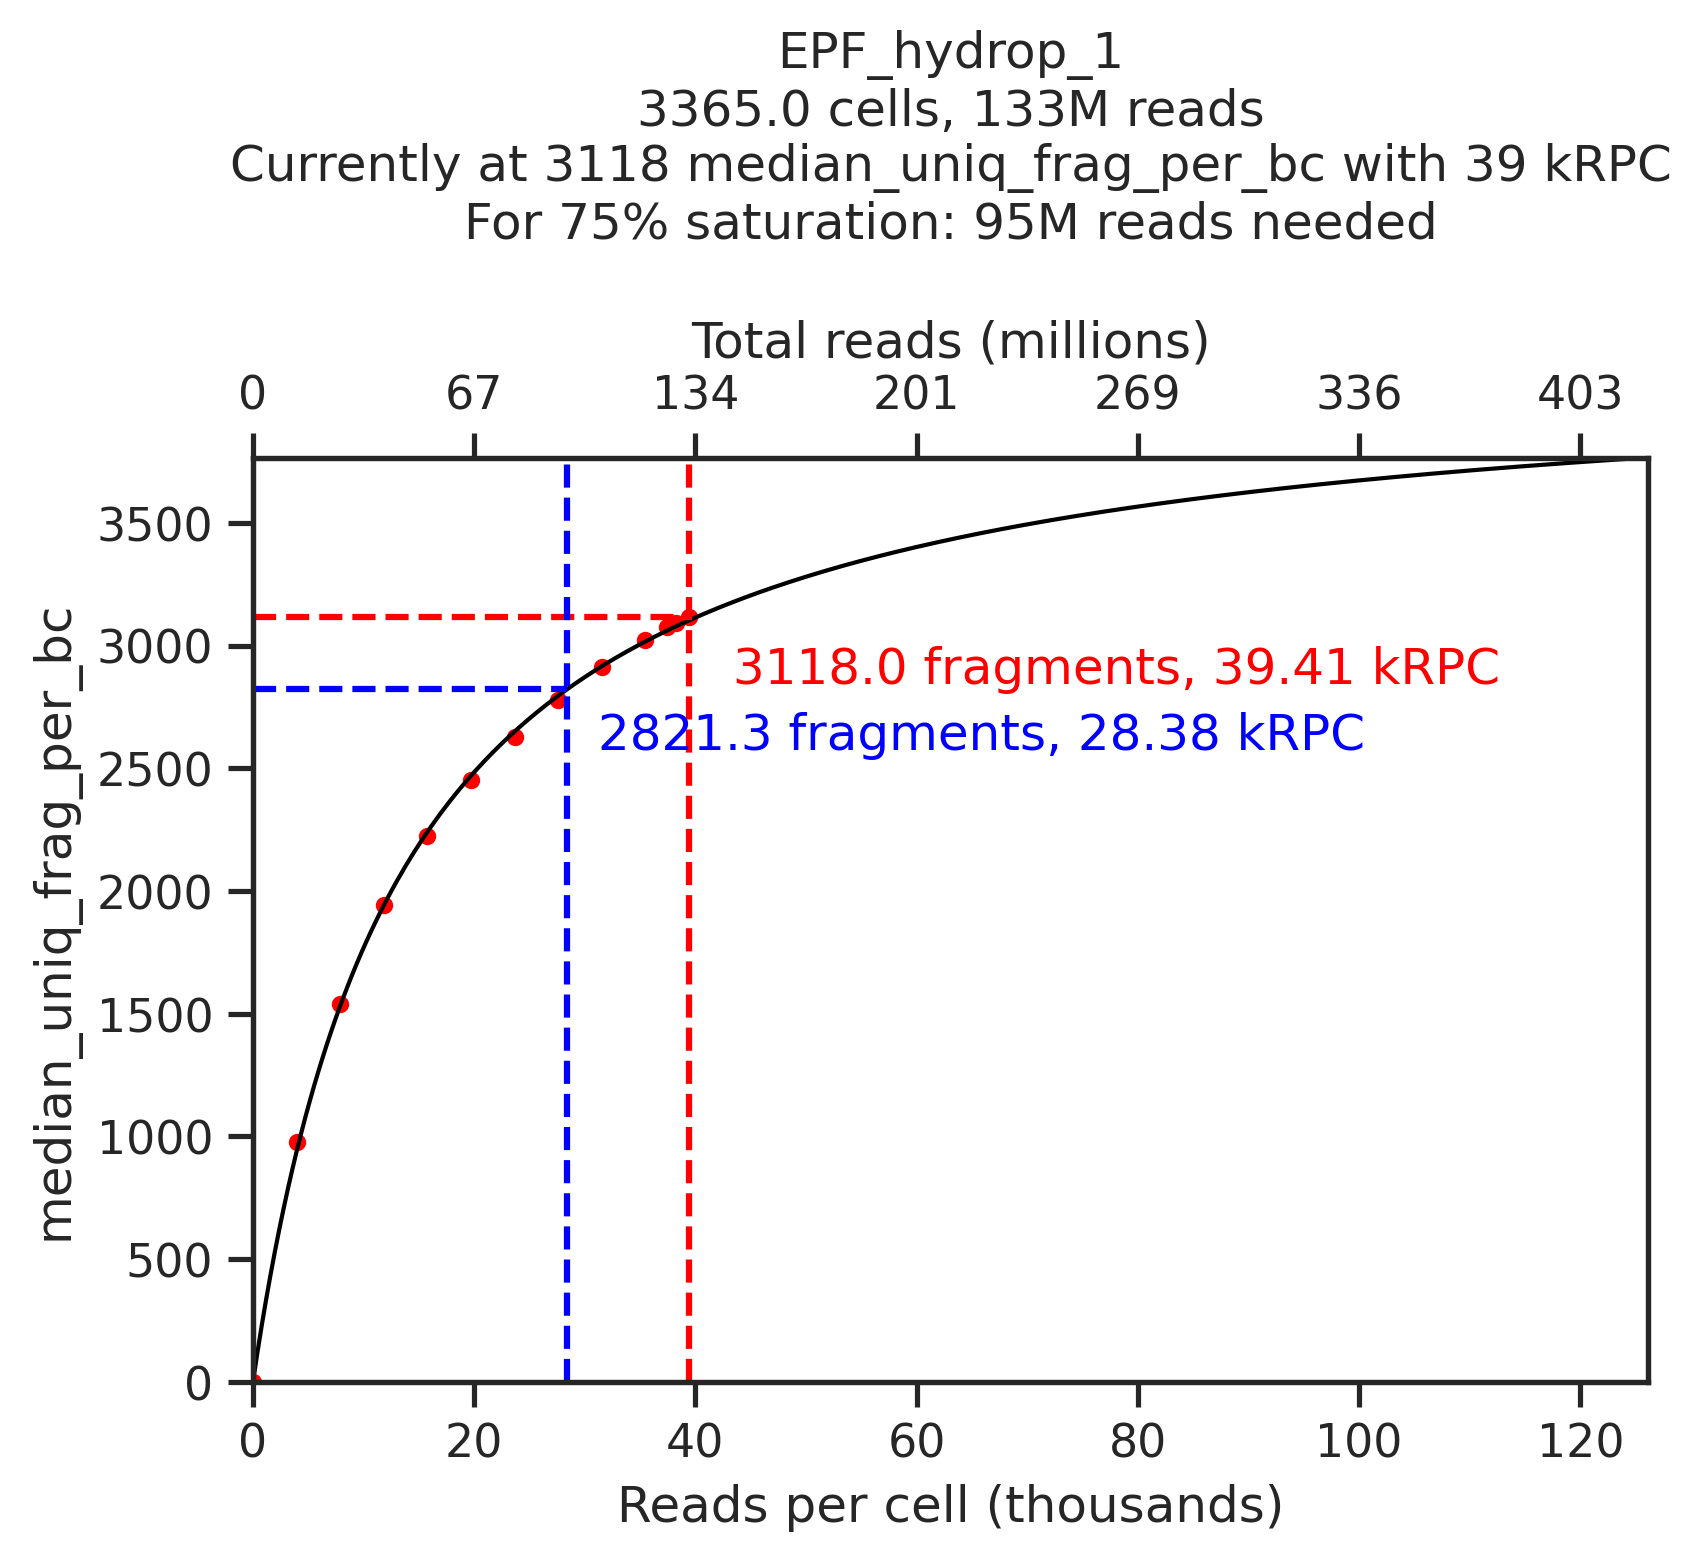

OHS_s3atac_1


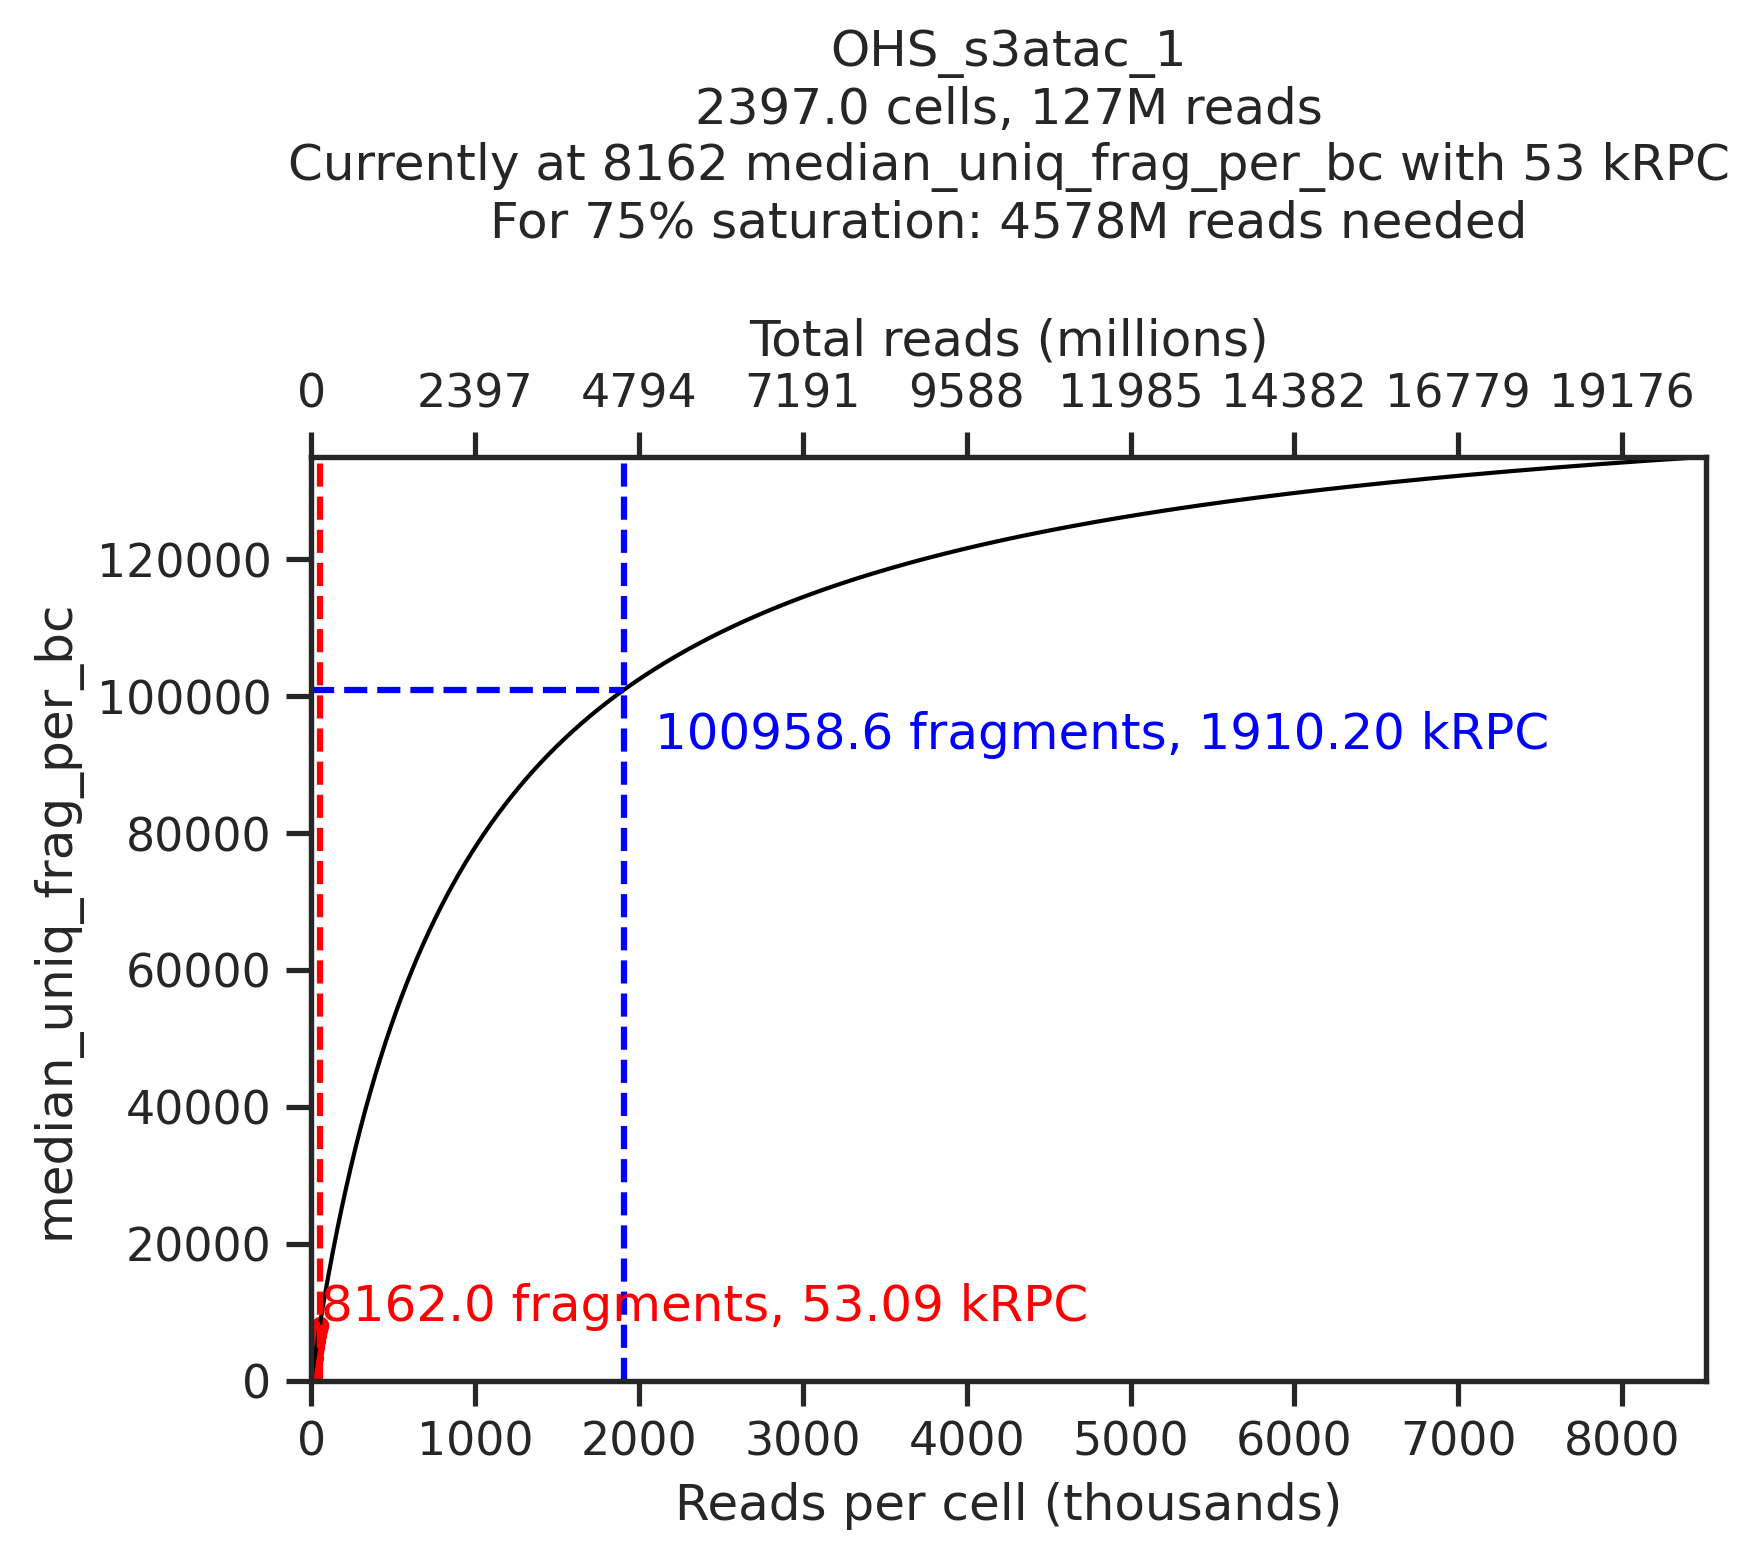

VIB_10xv2_1


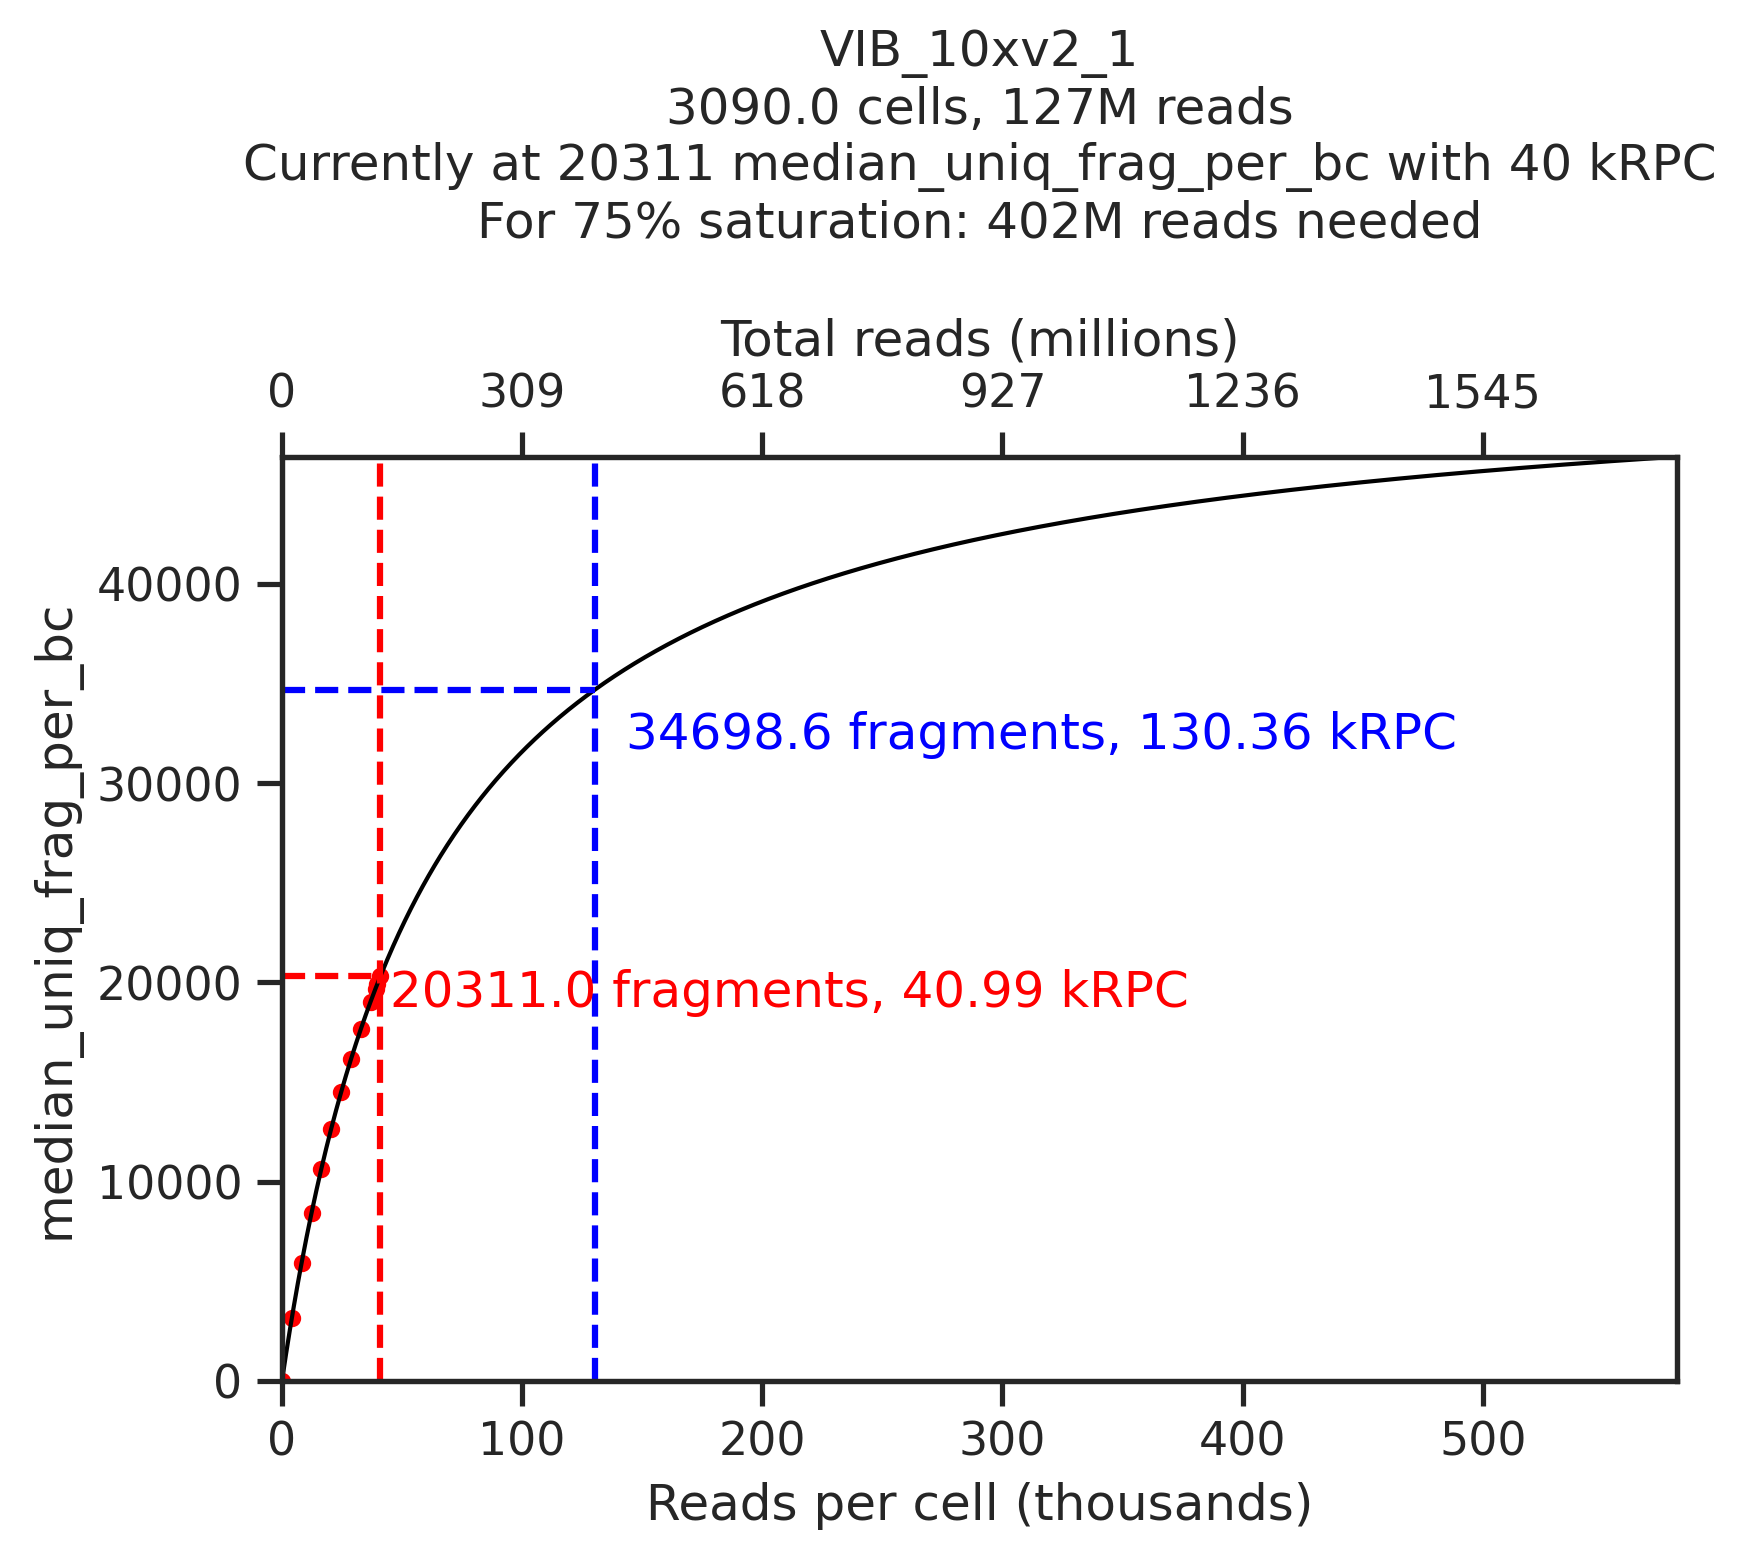

In [81]:
for sample in samples:
    print(sample)
    if not os.path.exists(f"plots_qc/{sample}__fragments_saturation.png"):
        pum.plot_saturation_fragments(
            sampling_stats_path_dict[sample],
            alias_dict[sample],
            df_stats.at[sample, "n_reads"],
            df_stats.at[sample, "n_cells"],
            x_axis="mean_reads_per_barcode",
            y_axis="median_uniq_frag_per_bc",
            function=MM,
            percentage_toplot=percentage_toplot,
            plot_current_saturation=True,
            svg_output_path=f"plots_qc/{sample}__fragments_saturation.svg",
            png_output_path=f"plots_qc/{sample}__fragments_saturation.png",
        )
    else:
        display(
            Image(filename=f"plots_qc/{sample}__fragments_saturation.png", width=600)
        )

Now, I want the duplication rate (fraction of fragments that are duplicates) on the y-axis instead. I also want to find the depth where 75% of reads are duplicates.

I use a michaelis-menten kinetic model with a maximum value fixed to 1 (number of duplicates cannot exceed 100%) to fit these values.

In [82]:
def MM_duplication(x, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Km > 0:
        y = x / (Km + x)
    else:
        y = 1e10
    return y

BIO_ddseq_4


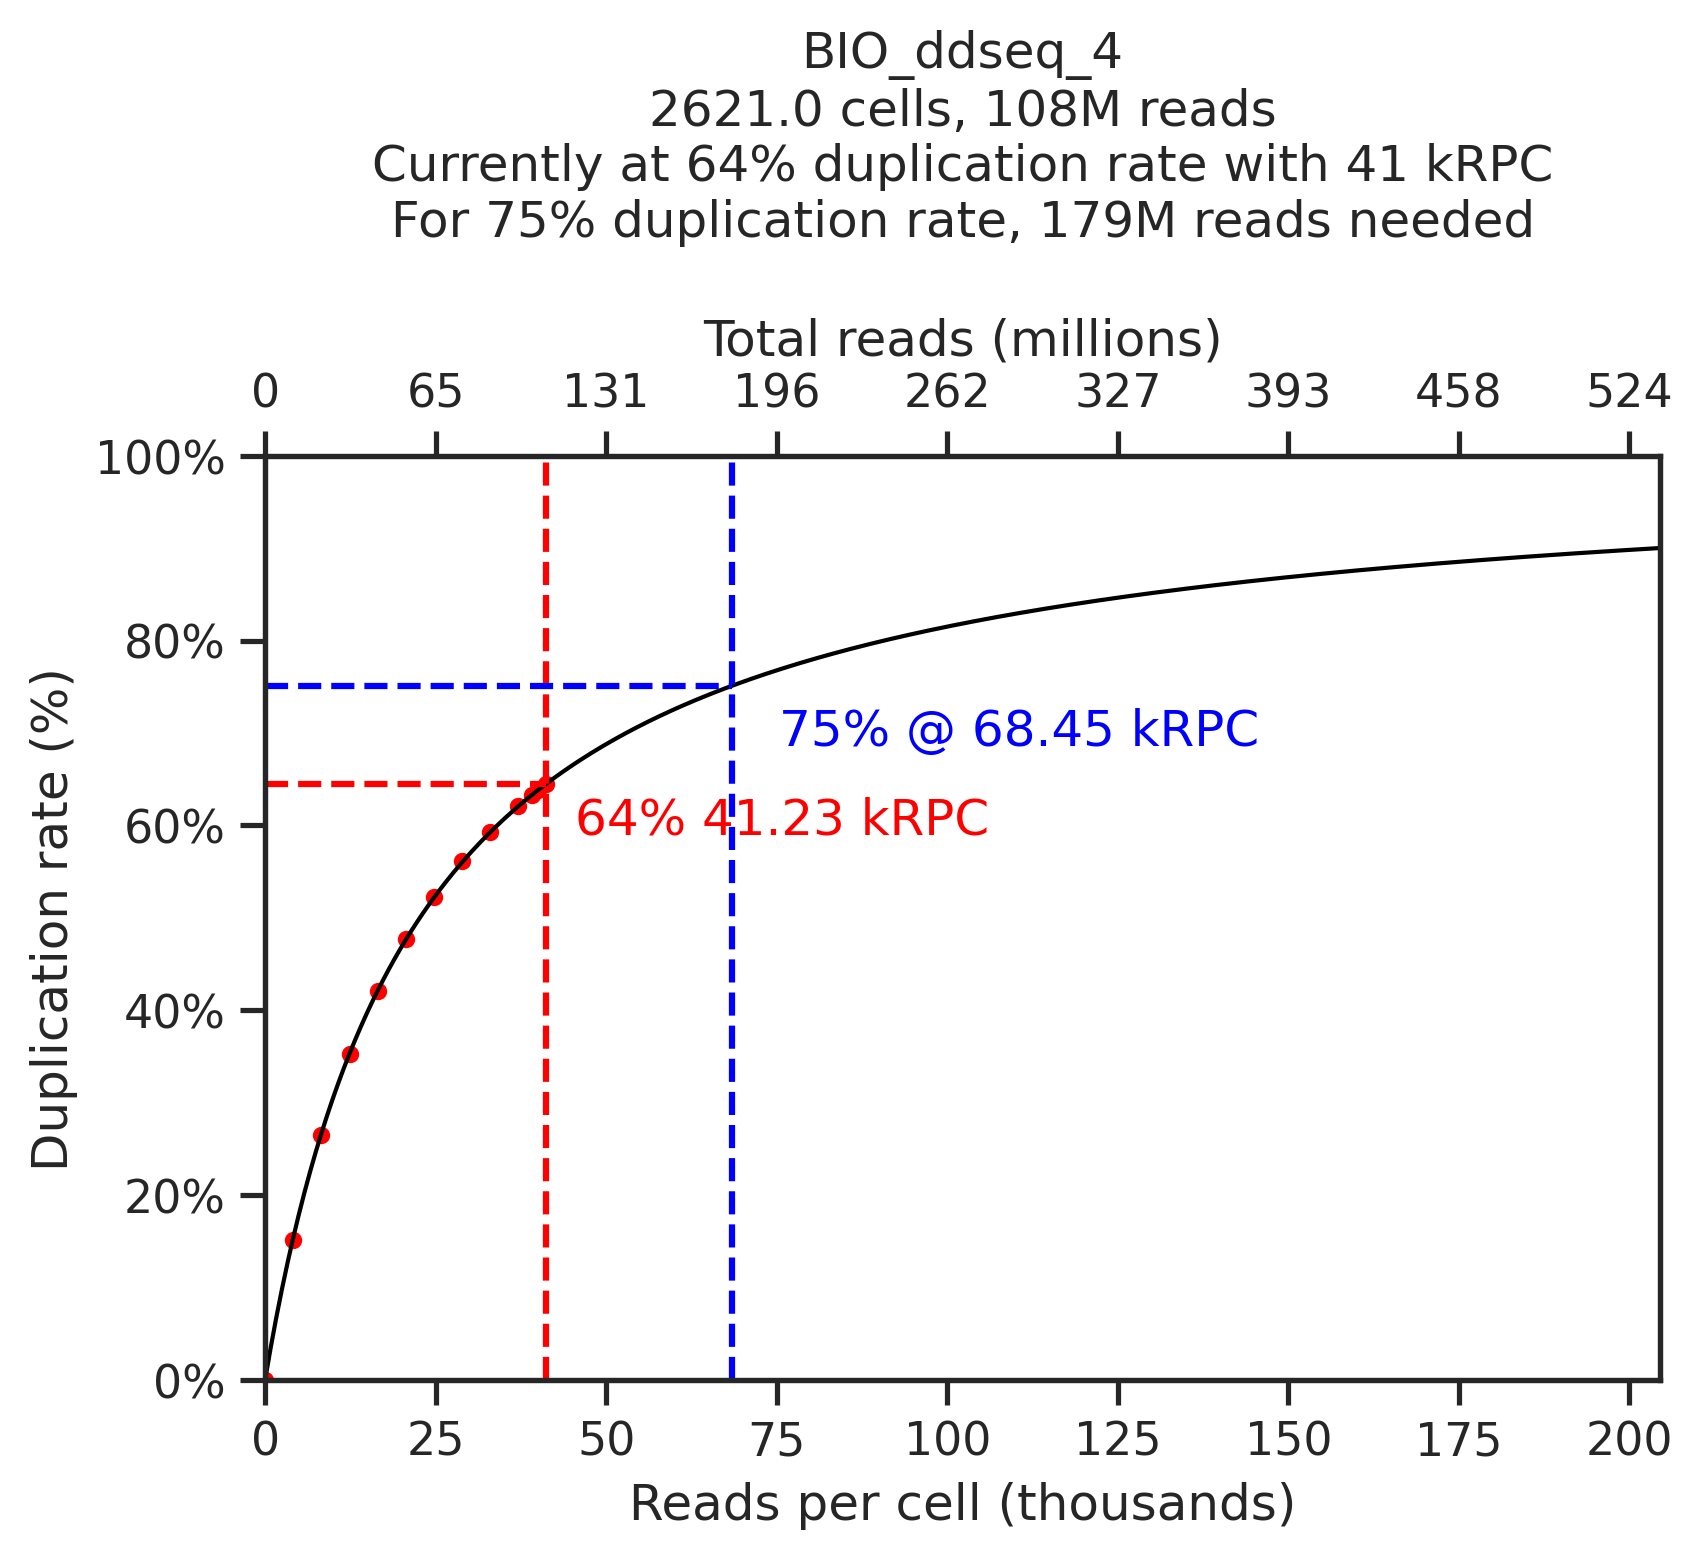

EPF_hydrop_1


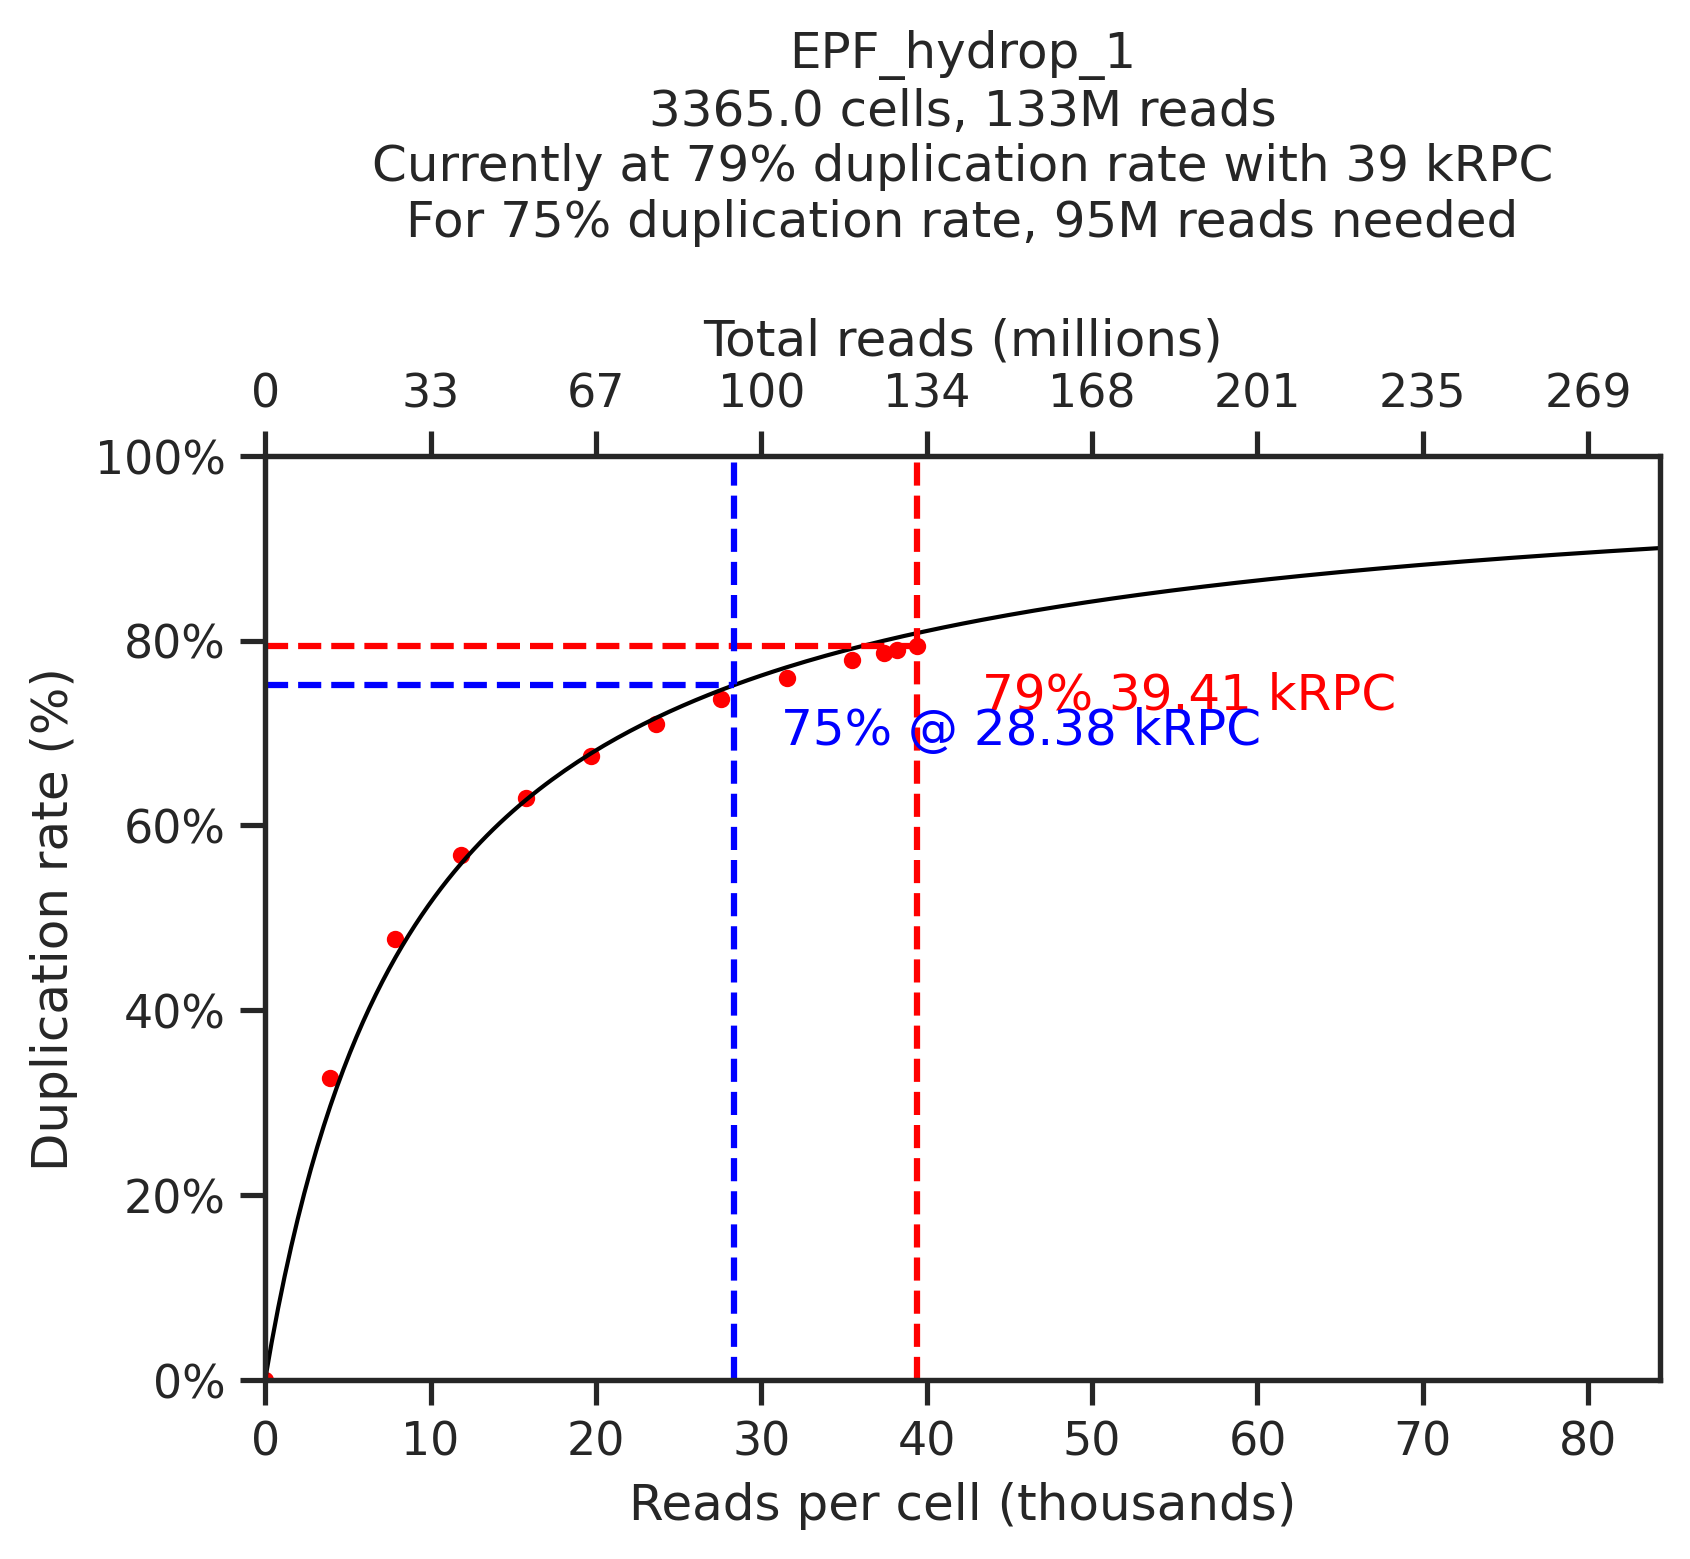

OHS_s3atac_1


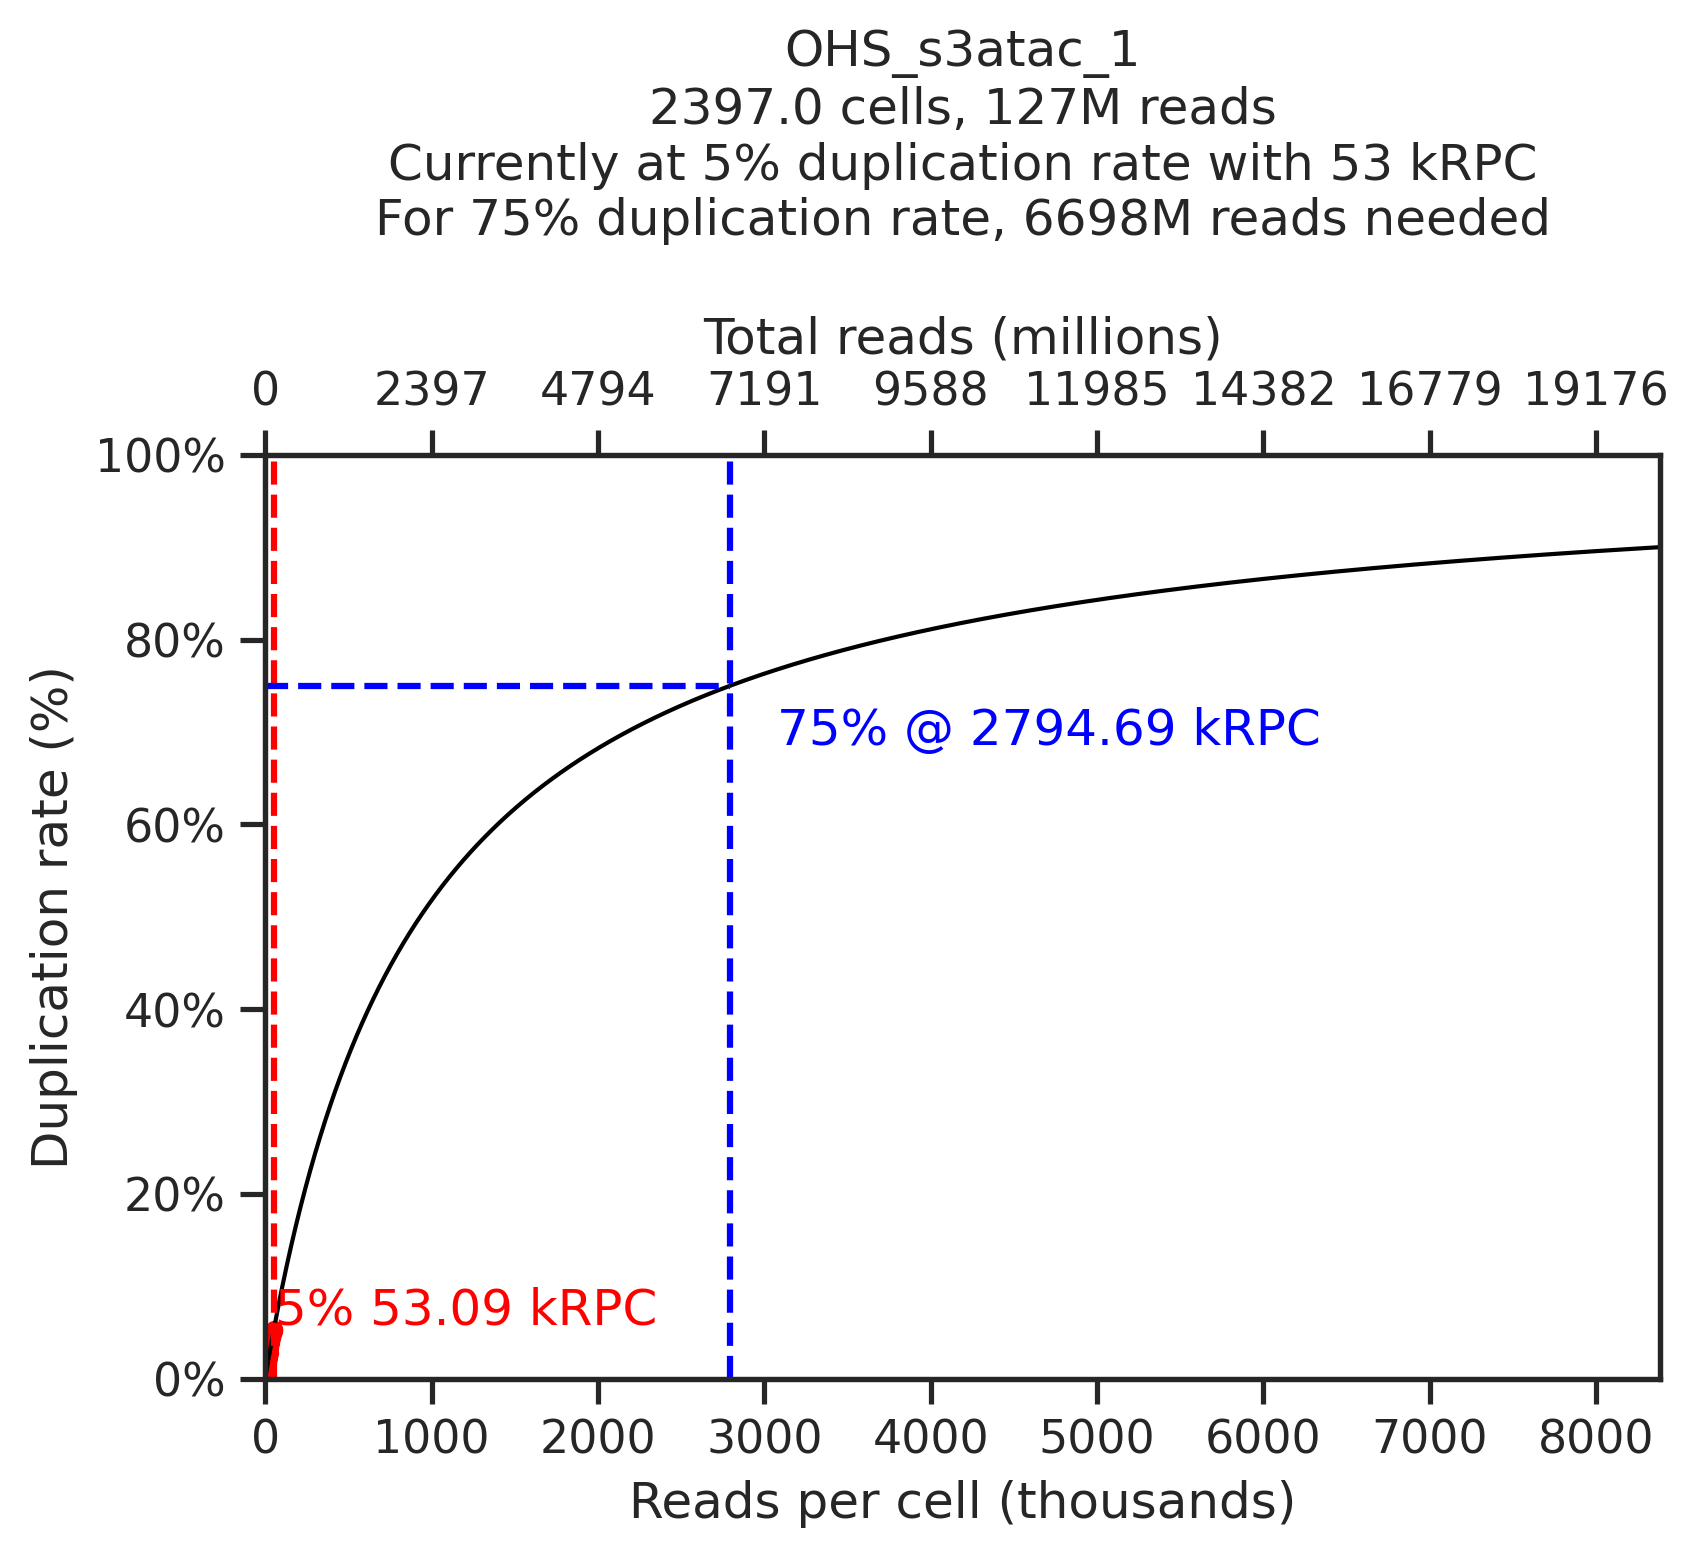

VIB_10xv2_1


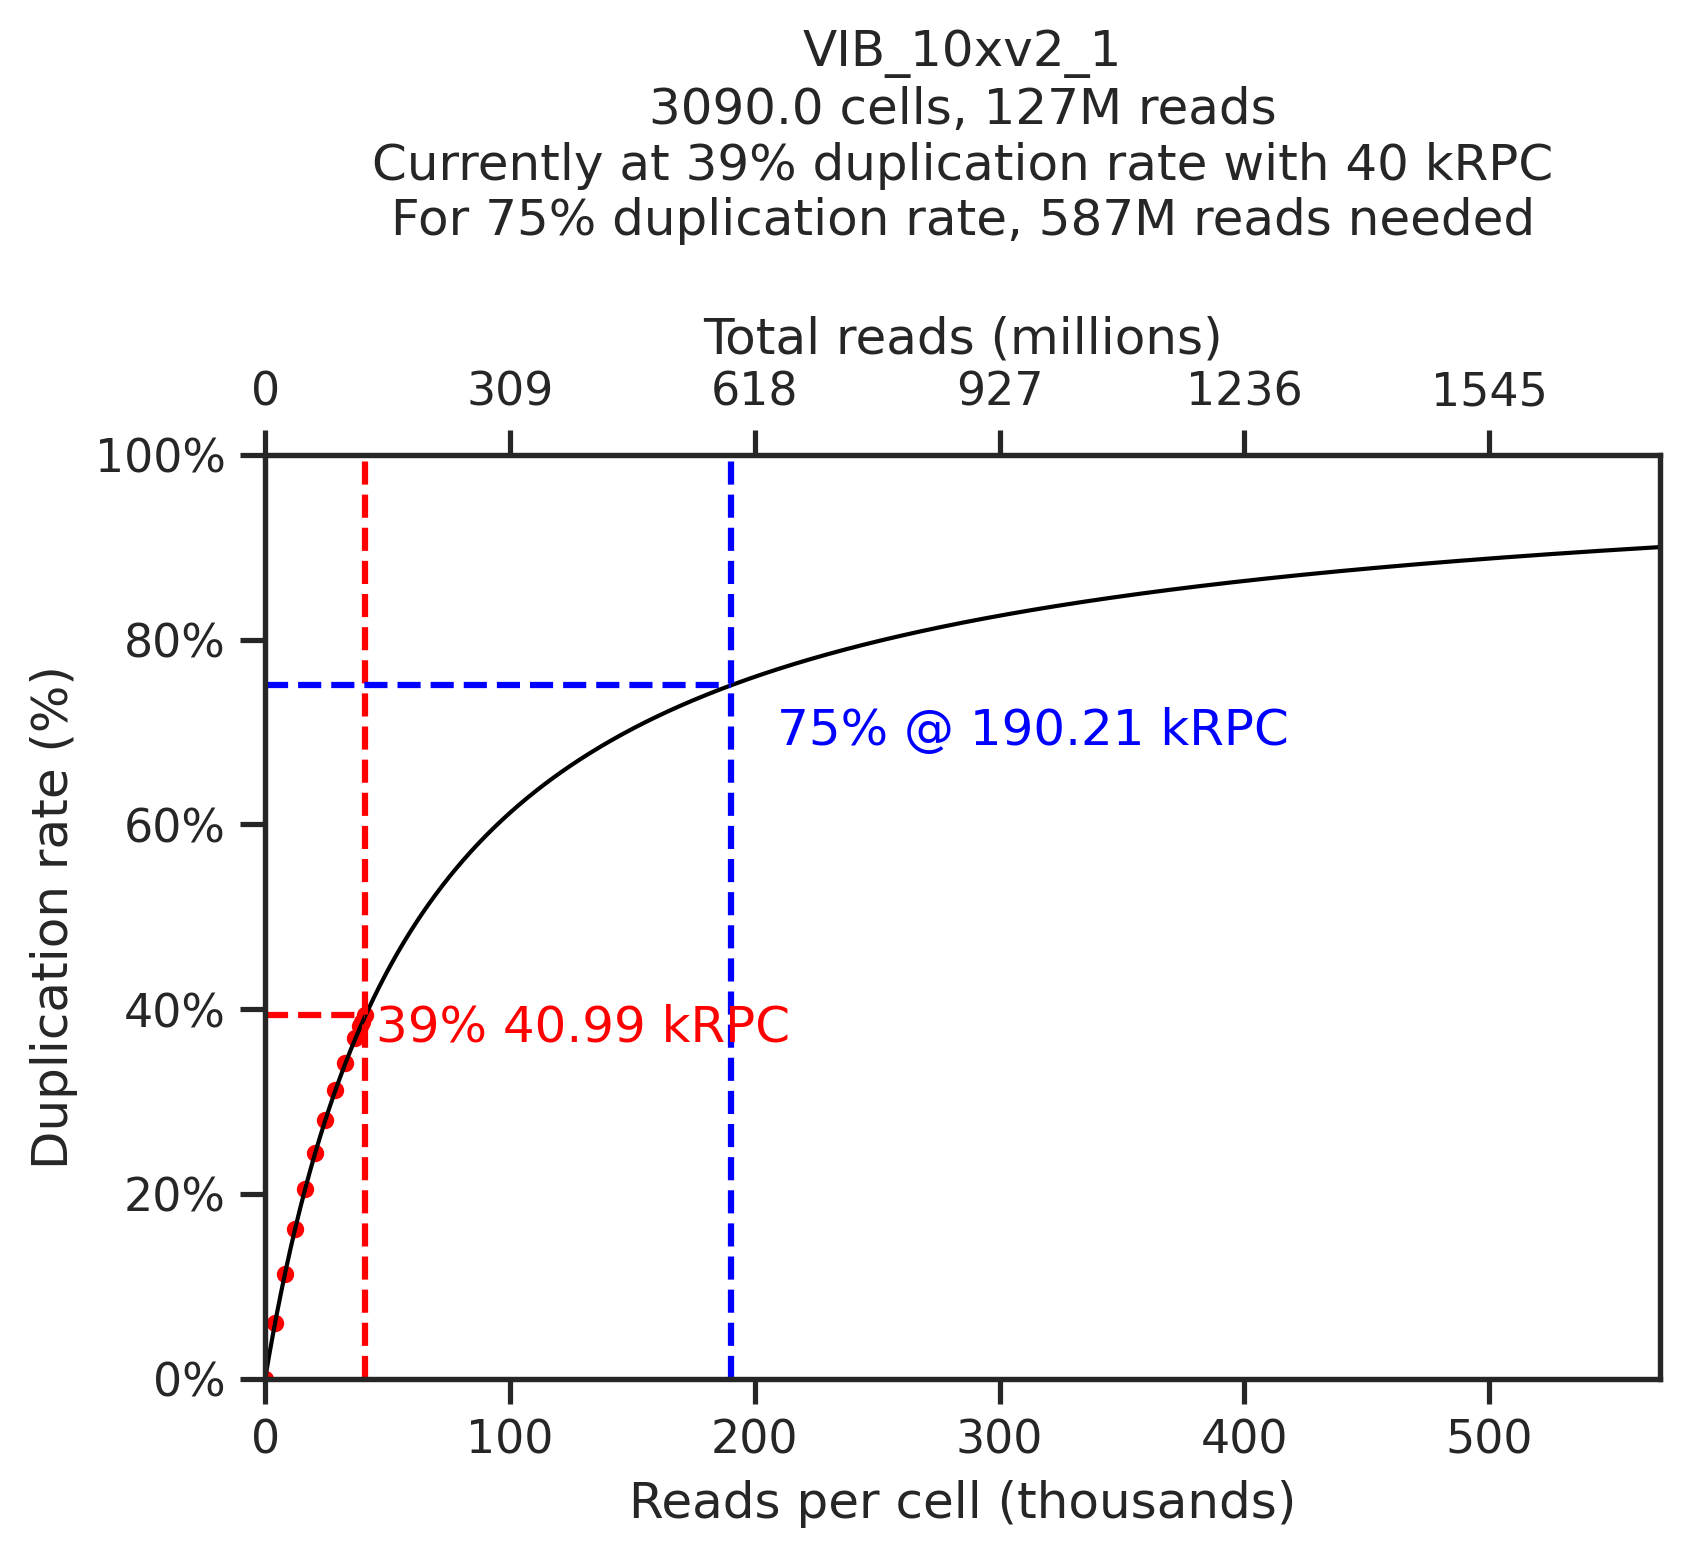

In [83]:
for sample in samples:
    print(sample)
    filepath = sampling_stats_path_dict[sample]
    n_reads = df_stats.at[sample, "n_reads"]
    if not os.path.exists(f"plots_qc/{sample}__duplication_saturation.png"):
        pum.plot_saturation_duplication(
            sampling_stats_path_dict[sample],
            alias_dict[sample],
            df_stats.at[sample, "n_reads"],
            df_stats.at[sample, "n_cells"],
            x_axis="mean_reads_per_barcode",
            y_axis="duplication_rate",
            function=MM_duplication,
            percentage_toplot=percentage_toplot,
            plot_current_saturation=True,
            svg_output_path=f"plots_qc/{sample}__duplication_saturation.svg",
            png_output_path=f"plots_qc/{sample}__duplication_saturation.png",
        )
    else:
        display(
            Image(filename=f"plots_qc/{sample}__duplication_saturation.png", width=600)
        )

### 4e. Combined plot

Feel free to give custom colors to each sample.

In [84]:
from scipy.optimize import curve_fit

function = MM
color_dict = {x: "black" for x in samples}
color_dict

{'BIO_ddseq_4': 'black',
 'EPF_hydrop_1': 'black',
 'OHS_s3atac_1': 'black',
 'VIB_10xv2_1': 'black'}

In [85]:
df_merged = pd.DataFrame()
for sample in samples:
    print(sample)
    df_tmp = pd.DataFrame(
        columns=["sample", "mean_reads_per_barcode", "median_uniq_frag_per_bc"]
    )
    filepath = sampling_stats_path_dict[sample]
    stats_df = pd.read_csv(filepath, sep="\t", index_col=0)

    n_reads = df_stats.at[sample, "n_reads"]
    x_data = np.array(stats_df.loc[0:, "mean_reads_per_barcode"]) / 10**3
    y_data = np.array(stats_df.loc[0:, "median_uniq_frag_per_bc"])

    # fit curve
    best_fit_ab, covar = curve_fit(function, x_data, y_data, bounds=(0, +np.inf))

    # expand fit space
    x_fit = np.linspace(0, int(np.max(x_data) * 1000), num=100000)
    y_fit = function(x_fit, *(best_fit_ab))
    # impute maximum saturation to plot as 95% of y_max
    y_val = best_fit_ab[0] * 0.95
    # subset x_fit space if bigger then y_val
    if y_val < max(y_fit):
        x_coef = np.where(y_fit >= y_val)[0][0]
        x_fit = x_fit[0:x_coef]
        y_fit = y_fit[0:x_coef]

    function(x_fit, *best_fit_ab)
    df_tmp["mean_reads_per_barcode"] = x_fit
    df_tmp["median_uniq_frag_per_bc"] = y_fit
    df_tmp["sample"] = alias_dict[sample]

    df_merged = pd.concat([df_merged, df_tmp])

BIO_ddseq_4
EPF_hydrop_1
OHS_s3atac_1
VIB_10xv2_1


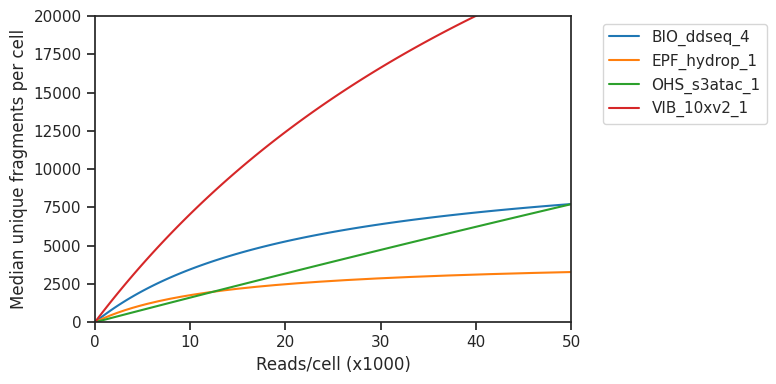

In [86]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(
    data=df_merged,
    x="mean_reads_per_barcode",
    y="median_uniq_frag_per_bc",
    hue="sample",
    ax=ax,
)
ax.set_xlim([0, 50])
ax.set_ylim([0, 20000])
ax.set_xlabel("Reads/cell (x1000)")
ax.set_ylabel("Median unique fragments per cell")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()
plt.savefig("plots_qc/all_saturation.png", dpi=300)

# 4f. Read-downsampled QC comparison

A common problem in these technical analyses is that all of your datasets are sequenced to different depths. Deeper sequencing will lead to more fragments detected per cell. For the most technically sound comparison, you should downsample all of your sequencing data to the highest common depth available, and then re-map the downsampled datasets. We did this in our 2023 NBT benchmark, but this is computationally expensive and takes a long time. A smarter approach is to use the saturation curves that we computed previously.  
  
A list of all the saturation curves that we calculated:

In [87]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'VIB_10xv2_1': 'saturation_stats/VIB_10xv2_1.sampling_stats.tsv'}

Then, we need to find the common depth to in-silico downsample all the samples to:

In [88]:
df_stats["rpc"] = df_stats["n_reads"] / df_stats["n_cells"]
min_rpc = df_stats["rpc"].min()
min_rpc

39425.18306092125

In the standard case, I will set the downsampling depth `to_downsample` as equal to `min_rpc`. Of course, you can change `to_downsample` to your liking (since we can even extrapolate values). If you downsample too much, you will favour methods that saturate faster. The inverse is also true.

In [89]:
to_downsample = min_rpc

Now, for every sample, calculate the expected median unique number of fragments per barcode at `to_downsample` reads per cell (as well as unique and total number of fragments in the fragments file to calculate duplication):.

In [90]:
to_downsample_projected_stats = pd.DataFrame()
for sample in samples:
    for variable in [
        "median_uniq_frag_per_bc",
        "total_unique_frag_count",
        "total_frag_count",
    ]:
        print(variable)
        to_downsample_projected_stats.at[sample, variable] = pum.get_fit(
            sampling_stats_path_dict[sample],
            alias_dict[sample],
            df_stats.at[sample, "n_reads"],
            df_stats.at[sample, "n_cells"],
            x_axis="mean_reads_per_barcode",
            y_axis=variable,
            function=MM,
            to_downsample=to_downsample,
            maxfev=5000,
        )
    to_downsample_projected_stats.at[sample, "total_reads"] = (
        min_rpc * df_stats.at[sample, "n_cells"]
    )

median_uniq_frag_per_bc
total_unique_frag_count
total_frag_count
median_uniq_frag_per_bc
total_unique_frag_count
total_frag_count
median_uniq_frag_per_bc
total_unique_frag_count
total_frag_count
median_uniq_frag_per_bc
total_unique_frag_count
total_frag_count


In [91]:
to_downsample_projected_stats.index = [
    alias_dict[x] for x in to_downsample_projected_stats.index
]
to_downsample_projected_stats["duplication_rate"] = 1 - (
    to_downsample_projected_stats["total_unique_frag_count"]
    / to_downsample_projected_stats["total_frag_count"]
)

So, at a sequencing depth of `to_downsample` reads per cell, we can expect the following:

In [92]:
to_downsample_projected_stats

median_uniq_frag_per_bc  total_unique_frag_count   
BIO_ddseq_4               7139.709820             1.966379e+07  \
EPF_hydrop_1              3102.544928             1.353337e+07   
OHS_s3atac_1              6127.772125             2.010437e+07   
VIB_10xv2_1              19813.292361             6.323841e+07   

              total_frag_count   total_reads  duplication_rate  
BIO_ddseq_4       5.399765e+07  1.033334e+08          0.635840  
EPF_hydrop_1      6.627955e+07  1.326657e+08          0.795814  
OHS_s3atac_1      2.095192e+07  9.450216e+07          0.040452  
VIB_10xv2_1       1.026621e+08  1.218238e+08          0.384014

Note that `total_unique_frag_count` and `total_frag_count` and thus `duplication_rate` are for valid cell barcodes only.

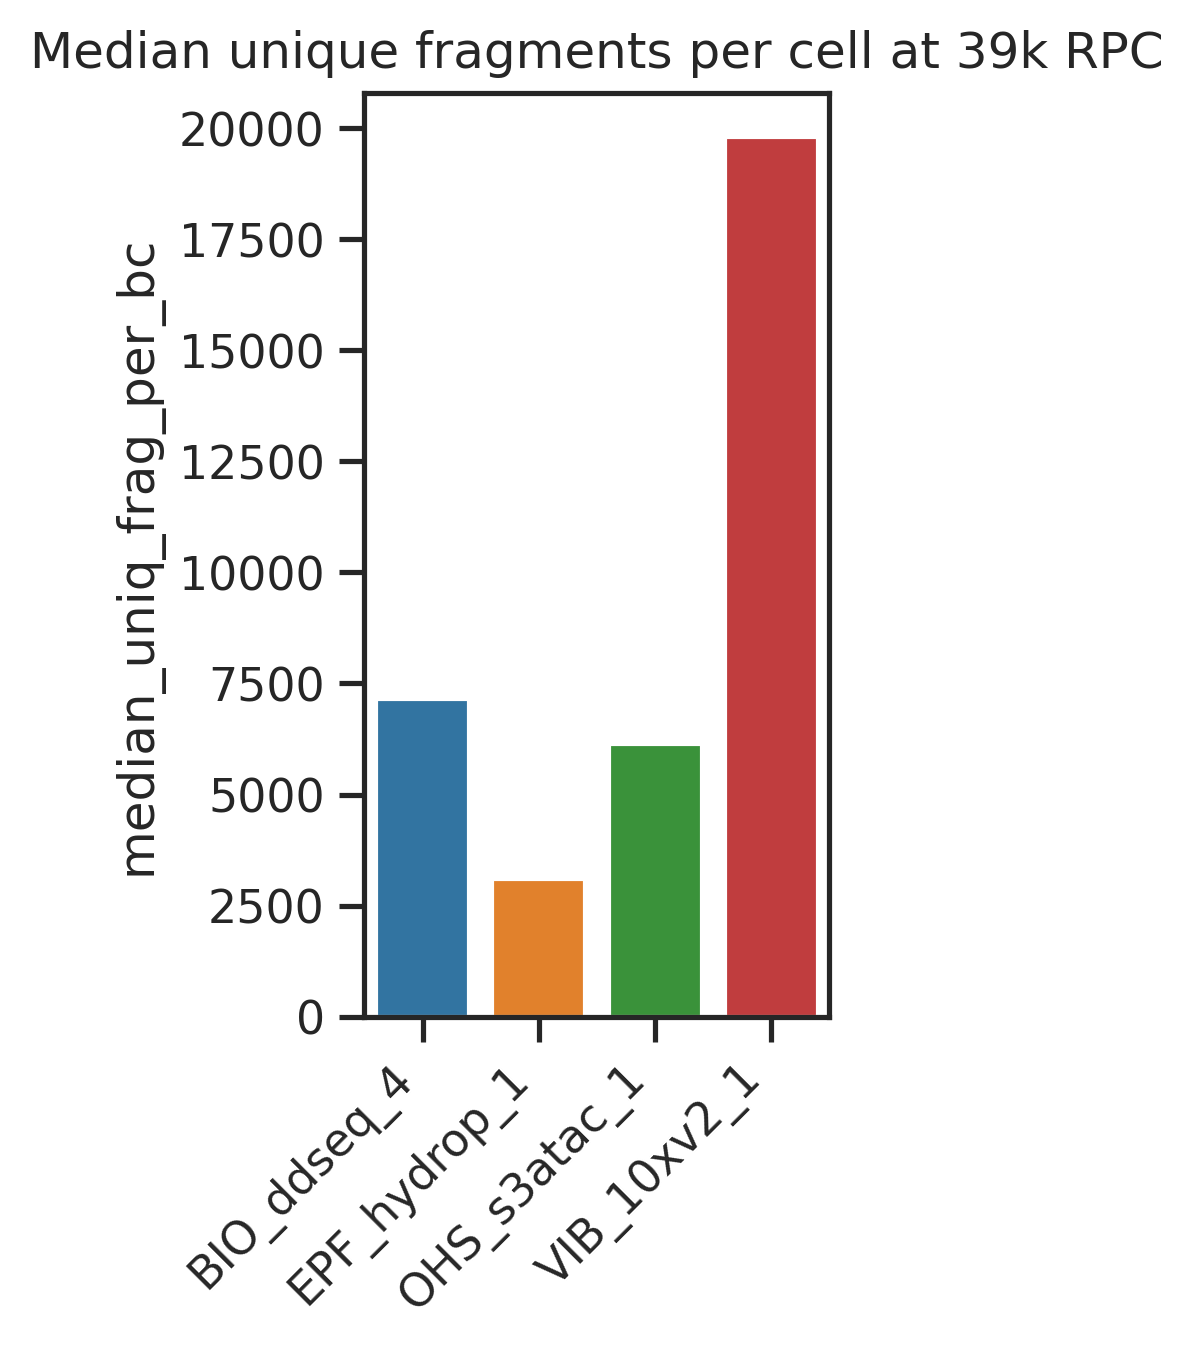

In [93]:
fig, ax = plt.subplots(dpi=300, figsize=(len(to_downsample_projected_stats) * 0.5, 4))
sns.barplot(
    data=to_downsample_projected_stats,
    x=to_downsample_projected_stats.index,
    y="median_uniq_frag_per_bc",
    ax=ax,
)
plt.title(f"Median unique fragments per cell at {int(to_downsample/1000)}k RPC")
plt.xticks(rotation=45, ha="right")
plt.savefig("plots_qc/all_saturation_frags.png", dpi=300)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'BIO_ddseq_4'),
  Text(1, 0, 'EPF_hydrop_1'),
  Text(2, 0, 'OHS_s3atac_1'),
  Text(3, 0, 'VIB_10xv2_1')])

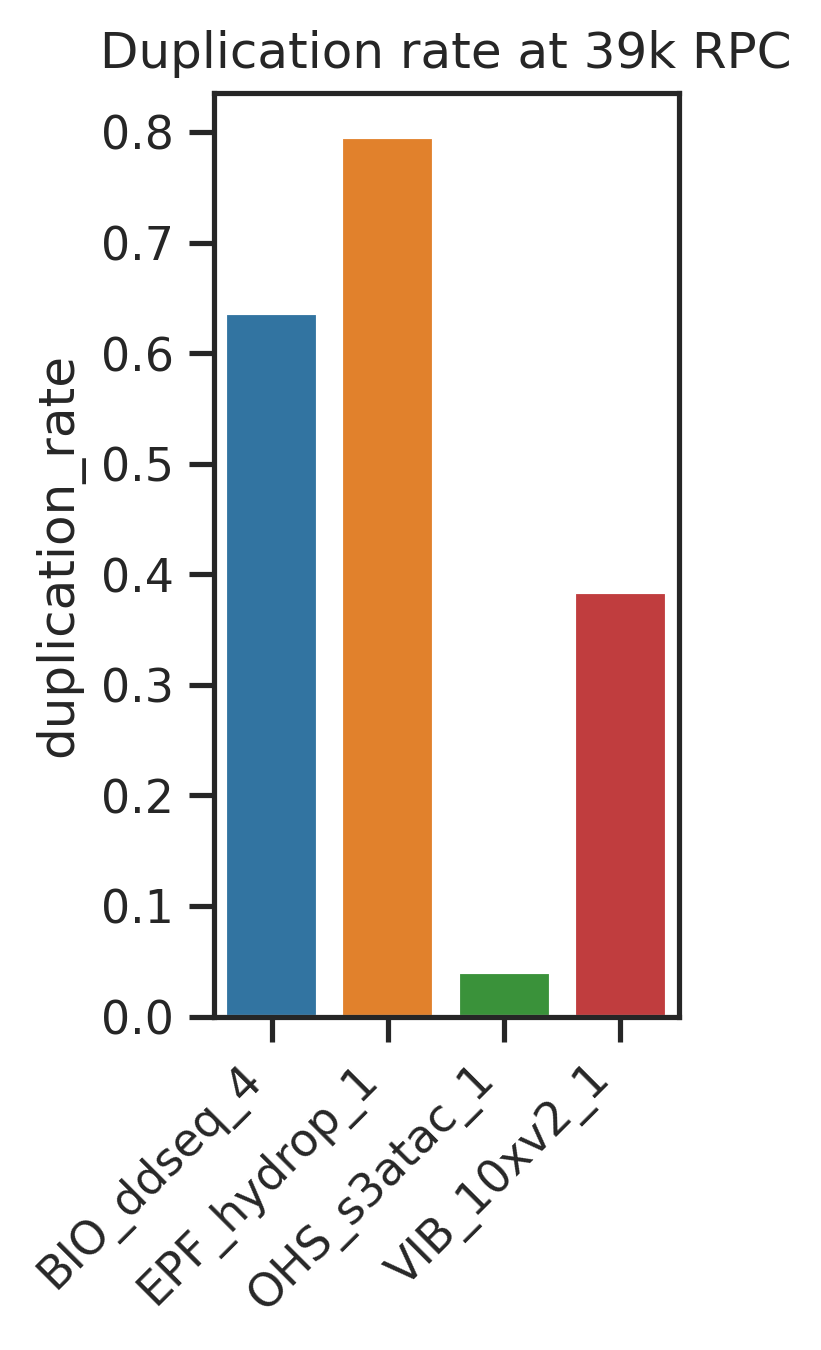

In [94]:
fig, ax = plt.subplots(dpi=300, figsize=(len(to_downsample_projected_stats) * 0.5, 4))
sns.barplot(
    data=to_downsample_projected_stats,
    x=to_downsample_projected_stats.index,
    y="duplication_rate",
    ax=ax,
)
plt.title(f"Duplication rate at {int(to_downsample/1000)}k RPC")
plt.xticks(rotation=45, ha="right")

With this information, we can adjust the sequencing efficiency stacked barplots:

In [95]:
to_downsample_projected_stats.index = [
    {alias_dict[x]: x for x in alias_dict.keys()}[x]
    for x in to_downsample_projected_stats.index
]

In [96]:
fraction_left = 1 - df_stats_merged[
    [
        "No correct barcode",
        "Not mapped properly",
        "Fragments in noise barcodes",
    ]
].sum(axis=1)

df_stats_merged["Duplicate fragments in cells (downsampled)"] = (
    (
        to_downsample_projected_stats["total_frag_count"]
        - to_downsample_projected_stats["total_unique_frag_count"]
    )
    / to_downsample_projected_stats["total_frag_count"]
    * fraction_left
)

median_frip = (
    df_stats_merged["total_nr_unique_frag_in_selected_barcodes_in_regions"]
    / df_stats_merged["total_nr_unique_frag_in_selected_barcodes"]
)

df_stats_merged["Unique, in cells, in peaks (downsampled)"] = median_frip * (
    fraction_left - df_stats_merged["Duplicate fragments in cells (downsampled)"]
)

df_stats_merged["Unique, in cells, not in peaks (downsampled)"] = (
    (1 - median_frip)
) * (fraction_left - df_stats_merged["Duplicate fragments in cells (downsampled)"])

/lustre1/project/stg_00002/lcb/fderop/data/20231115_hydrop_v2/PUMATAC_tutorial/pypumatac.py:2087: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


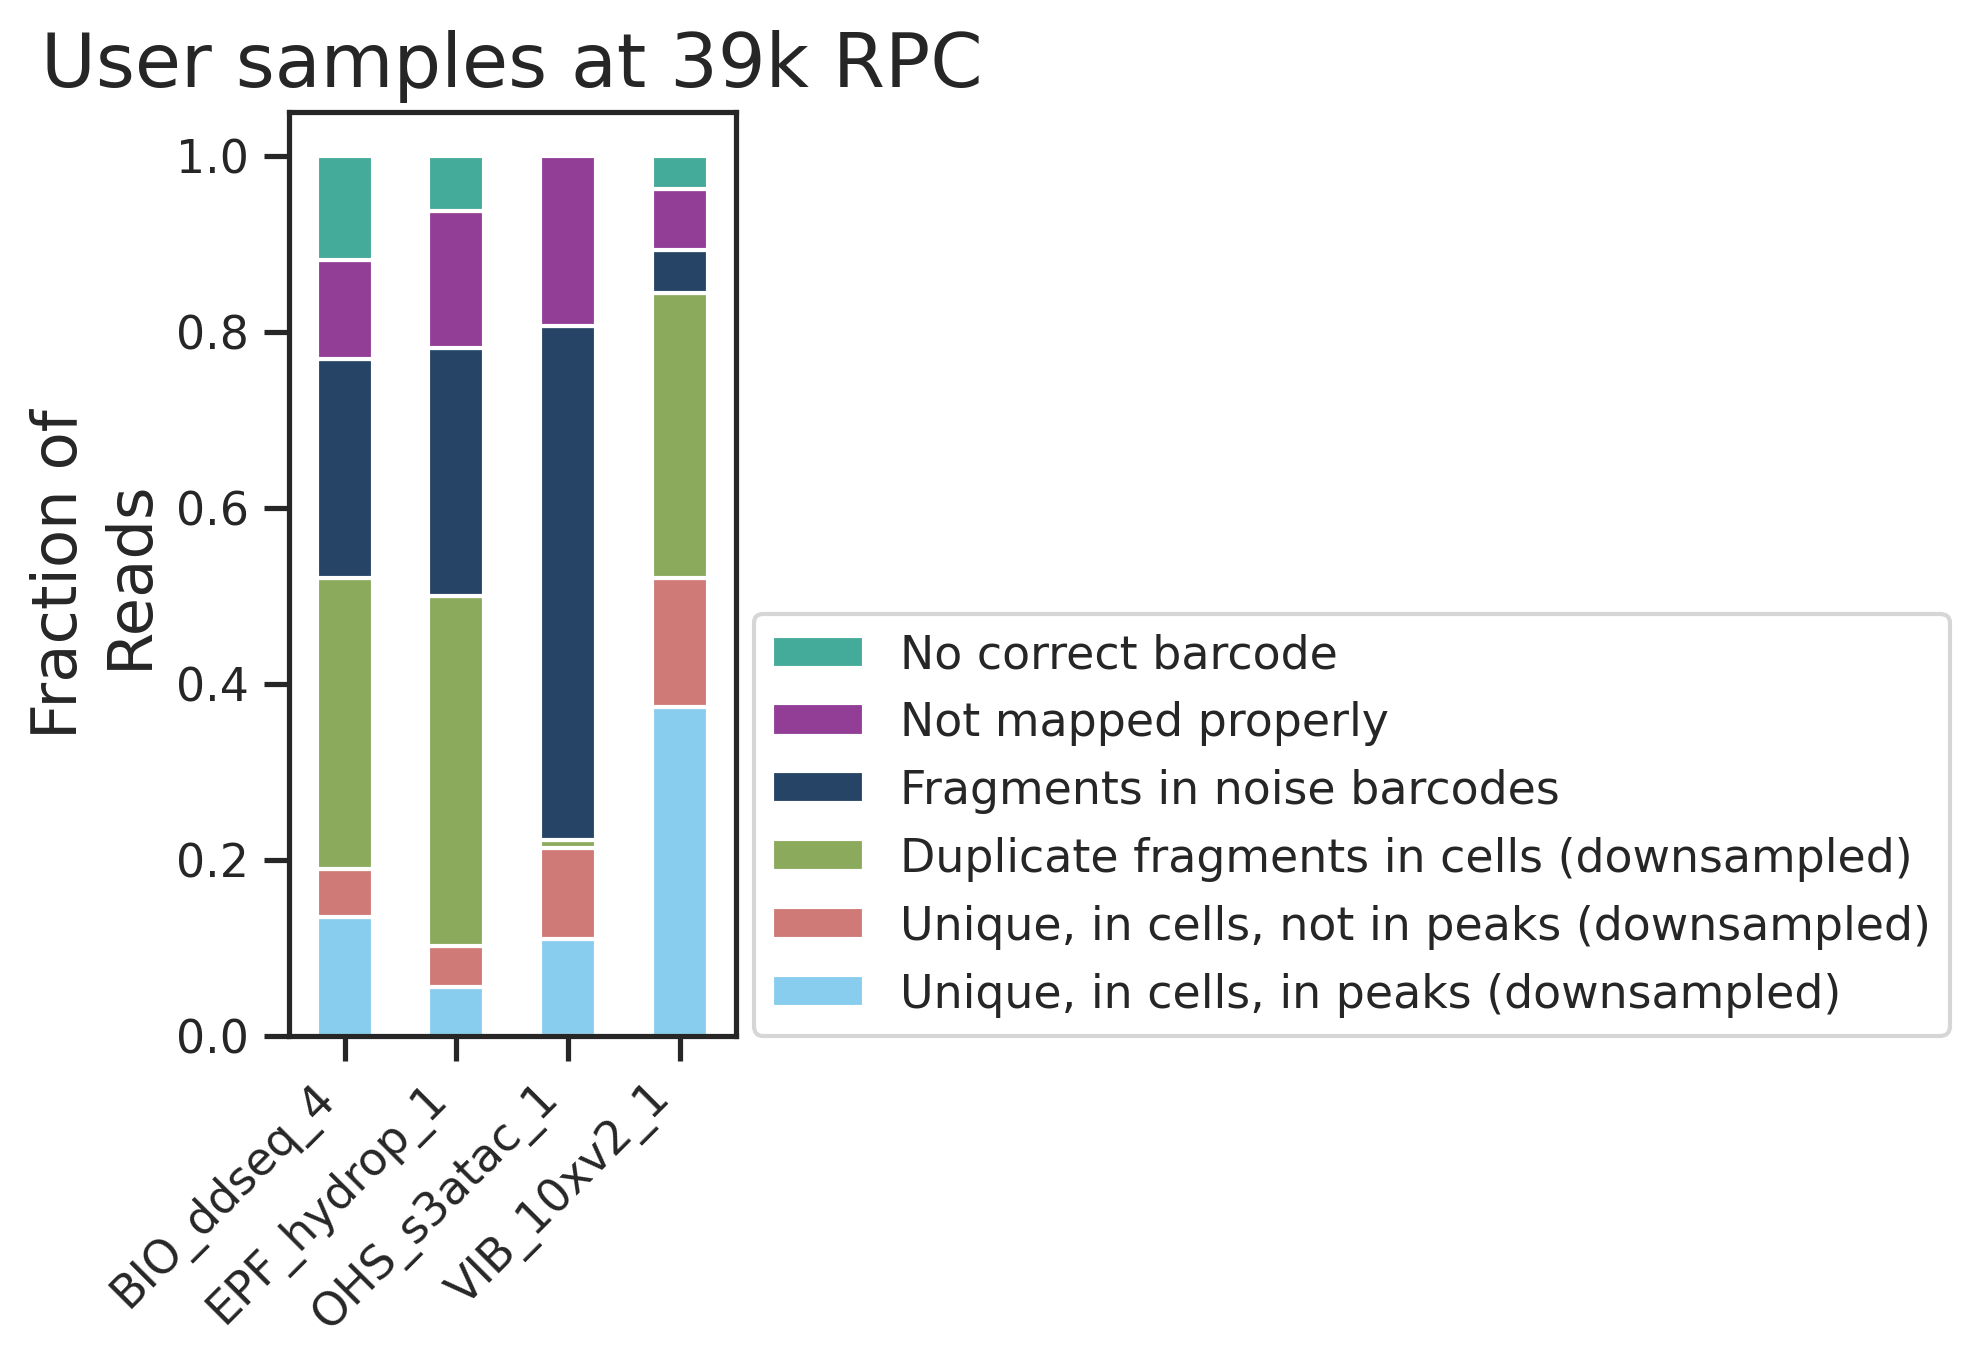

In [97]:
pum.plot_losses_downsampled(
    df_stats_merged=df_stats_merged,
    sample_order=samples,
    sample_alias_dict=alias_dict,
    tech_order=["user_sample"],
    svg_output_path="plots_qc/usersamples_barplots_downsampled.svg",
    png_output_path="plots_qc/usersamples_barplots_downsampled.png",
    depth=to_downsample,
)

Note that this is an approximation, as we do not re-filter cells. In reality, downsampling the dataset will most likely have an effect on the cell selection process. The magnitude of this effect will depend on the separation quality between true cells and noise. When true cells separate well from noise, downsampling has little effect.